<h1><b>Zebra Project 🦓</b></h1>

<a href="https://colab.research.google.com/drive/1qCTnIY36rMGk_oIEAksNluO8WJ-Ppfed?usp=sharing" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




#Resources


*   <b>GitHub Repository</b>: https://github.com/vgentile98/zebraproject
*   <b>Google Doc:</b> https://docs.google.com/document/d/11Q1ynH7498Pkmoe1UQTVuvr8zzTAIlCpE_L2xu3RpdE/edit
*   <b>Canva Presentation:</b> https://www.canva.com/design/DAFxCBko9SI/-m-ZGnVbyZqNDBfezkHZ4g/edit
*   <b>World Bank:</b> https://pypi.org/project/wbgapi/



#Libraries Import 📚

In [ ]:
pip install graphviz

In [ ]:
pip install wbgapi

In [ ]:
pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 28.7 MB/s eta 0:00:00


In [ ]:
pip install stargazer

In [ ]:
!pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import wbgapi as wb
import shapefile as shp
import itertools

from scipy.stats import skew, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pycountry
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from functools import reduce
import graphviz as gr

#Variables Selection 👀



*   **Dependent variable**: Environmental Policy Stringency Index
    *   The index measures the degree to which environmental policies put an explicit or implicit price on polluting or environmentally harmful behaviour. The index ranges from 0 (not stringent) to 6 (highest degree of stringency) and is based on the degree of stringency of 14 environmental policy instruments, both market-based and non-market-based, primarily related to climate and air pollution. These policy instruments include environmental taxes on SOx, NOx, diesel, and CO2; trading schemes in CO2; renewable energy and energy efficiency certificates; feed-in tariffs on solar and wind energy; deposit and refund schemes; emission limit values on NOx, SOx, PMx and sulphur content limits in diesel, as well as government expenditure on research and development within renewable energy.
    *   https://www.qogdata.pol.gu.se/data/codebook_ei_sept21_august2023.pdf

*   **Independent variable**: Proportion of seats held by women in national parliaments (%)
    *   https://databank.worldbank.org/source/gender-statistics
*   **Control variables**: GDP per capita, trade openness, co2 emissions per capita, education
*   **Heterogeneity variables**: Fertility rate
    * Total fertility rate represents the number of children that would be born to a woman if she were to live to the end of her childbearing years and bear children in accordance with age-specific fertility rates of the specified year.


#Sample Selection 🥢




##<h3>1) World Bank Group (WBG)</h3>


In [ ]:
#wb.source.info()

### <h4>1.1) Gender Statistics Dataset</h4>
Getting the <b>percentage of seats held by women in national parliaments</b> and the <b>fertility rate</b>.

In [ ]:
# Fetching dataset 14 (Gender Statistics)
wb.db = 14

In [ ]:
# Fetch data on proportion of seats held by women in national parliaments
df_wbg_women_seats = wb.data.DataFrame(['SG.GEN.PARL.ZS'], labels=True).reset_index()

In [ ]:
# Fetching data on fertility rate
df_wbg_fertility_rate = wb.data.DataFrame(['SP.DYN.TFRT.IN'], labels=True).reset_index()

### <h4>1.2) World Development Indicators Dataset</h4>
Getting the <b>GDP per capita (constant LCU)</b>, <b>trade openness</b>, and <b>CO2 emissions per capita</b>.

In [ ]:
# Fetching dataset 2 (World Development Indicators)
wb.db = 2

In [ ]:
# Fetch data on gdp per capita
df_wbg_gdp = wb.data.DataFrame(['NY.GDP.PCAP.KN'], labels=True).reset_index()

In [ ]:
# Fetch data on trade openness
df_wbg_openness = wb.data.DataFrame(['NE.TRD.GNFS.ZS'], labels=True).reset_index()

In [ ]:
# Fetch data on CO2 emissions per capita
df_wbg_co2 = wb.data.DataFrame(['EN.ATM.CO2E.PC'], labels=True).reset_index()

### <h4>1.3) Education Statistics Dataset</h4>
Getting the <b>years of education</b>.

In [ ]:
# Fetching dataset 12 (Education Statistics)
wb.db = 12

In [ ]:
# Fetch data on years of education of total population of 15+ years old
df_wbg_education = wb.data.DataFrame(['BAR.SCHL.15UP.FE'], labels=True).reset_index()

/usr/local/lib/python3.10/dist-packages/wbgapi/data.py:343: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index_key, column_key] = np.nan if row['value'] is None else row['value']


### <h4>1.4) Merging Datasets from WBG</h4>

In [ ]:
# Defining a function for rearranging WBG datasets
def rearrange(df, value_name):
    # Reshape dataframes to have the year as a separate column
    df = df.melt(id_vars=["economy", "Country"], var_name="year", value_name=value_name)
    # Extract the year column and make sure its type is integer
    df['year'] = df['year'].astype(str).str.extract('(\d+)').astype(int)
    df = df.rename(columns={'economy': 'country_code', 'Country': 'country_name'})
    return df

In [ ]:
# Rearranging dataframes
df_wbg_women_seats_melted = rearrange(df_wbg_women_seats, "women_seats")
df_wbg_fertility_rate_melted = rearrange(df_wbg_fertility_rate, "fertility_rate")
df_wbg_gdp_melted = rearrange(df_wbg_gdp, "gdp")
df_wbg_education_melted = rearrange(df_wbg_education, "education")
df_wbg_co2_melted = rearrange(df_wbg_co2, "co2")
df_wbg_openness_melted = rearrange(df_wbg_openness, "openness")

In [ ]:
# Drop the 'country_name' column from all but one dataframe
# List of dataframes from which to drop 'country_name'
dataframes_to_modify = [df_wbg_fertility_rate_melted, df_wbg_gdp_melted, df_wbg_openness_melted, df_wbg_co2_melted, df_wbg_education_melted]

# Loop through each dataframe and drop the 'country_name' column
for df in dataframes_to_modify:
    df.drop('country_name', axis=1, inplace=True)

In [ ]:
# Merge dataframes
# List of all dataframes to be merged
dataframes_to_merge = [df_wbg_women_seats_melted, df_wbg_fertility_rate_melted, df_wbg_gdp_melted, df_wbg_openness_melted, df_wbg_co2_melted, df_wbg_education_melted]

# Using reduce to merge all dataframes on 'country_code' and 'year'
df_wbg_merged = reduce(lambda left, right: pd.merge(left, right, on=['country_code', 'year']), dataframes_to_merge)

## <h3>2) QoG</h3>
Getting the <b>environmental policy stringency index</b> and <b>gender quotas</b>.

### <h4>2.1) QoG Environmental Indicators Dataset</h4>
**bold text**

In [ ]:
# Import data from QoG Environmental Indicators Dataset
df_qog = pd.read_excel('https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx')

In [ ]:
# Select a subset of variables
df_qog = df_qog[['cname_wb', 'ccodealp', 'year', 'oecd_eps']].copy()

# Rename & select columns
df_qog.rename(columns={"cname_wb": "country_name", "ccodealp": "country_code", "oecd_eps": "stringency_index"}, inplace=True)
df_qog = df_qog[['country_code', 'year', 'stringency_index']]

df_qog

,country_code,year,stringency_index
0,AFG,1946,NaN
1,AFG,1947,NaN
2,AFG,1948,NaN
3,AFG,1949,NaN
4,AFG,1950,NaN
...,...,...,...
11717,VDR,1972,NaN
11718,VDR,1973,NaN
11719,VDR,1974,NaN
11720,VDR,1975,NaN


### <h4>2.2) QoG Quota Adoption and Reform over Time Dataset</h4>


In [ ]:
# Import data from Quota Adoption and Reform over Time Dataset
df_qog_quota = pd.read_excel("https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/qogdata_18_12_2023.xlsx")

In [ ]:
# Keep only relevant columns
df_qog_quota = df_qog_quota[["ccodealp", "year", "qar_efqu"]].copy()
df_qog_quota.rename(columns={'ccodealp': 'country_code', 'qar_efqu': 'quota'}, inplace=True)

df_qog_quota.head()

,country_code,year,quota
0,AFG,1947,0
1,AFG,1948,0
2,AFG,1949,0
3,AFG,1950,0
4,AFG,1951,0


## <h3>3) Polity5</h3>
Getting the <b>polity score</b>.

In [ ]:

# Import data from Polity5 Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/p5v2018_ISO_final.xls"
df_polity=pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["scode", "year", "polity"]
df_polity = df_polity[columns_to_keep]

# Rename & select columns
df_polity.rename(columns={"scode": "country_code"}, inplace=True)

df_polity

,country_code,year,polity
0,AFG,1800,-6
1,AFG,1801,-6
2,AFG,1802,-6
3,AFG,1803,-6
4,AFG,1804,-6
...,...,...,...
17569,ZIM,2014,4
17570,ZIM,2015,4
17571,ZIM,2016,4
17572,ZIM,2017,4


In [ ]:
# Filter rows where country_code is 'CHE'
df_che = df_polity[df_polity['country_code'] == 'CHE']

# Displaying the filtered DataFrame
print(df_che)

      country_code  year  polity
14912          CHE  1848      10
14913          CHE  1849      10
14914          CHE  1850      10
14915          CHE  1851      10
14916          CHE  1852      10
...            ...   ...     ...
15078          CHE  2014      10
15079          CHE  2015      10
15080          CHE  2016      10
15081          CHE  2017      10
15082          CHE  2018      10

[171 rows x 3 columns]


## <h3>4) UN women right to vote</h3>

In [ ]:
# Import data from Women Right to Vote Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/women_right_final_english_3_letter_ISO_final.xls"
df_women_voting_right=pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["country_code", "women_voting_right_year"]
df_women_voting_right = df_women_voting_right[columns_to_keep]

df_women_voting_right

,country_code,women_voting_right_year
0,ALB,1920
1,ARM,1921
2,AZE,1921
3,BLR,1919
4,BIH,1949
...,...,...
61,IND,1950
62,BRA,1932
63,MEX,1947
64,KOR,1948


In [ ]:
# Création d'une liste d'années de 1997 à 2023
#years = list(range(1997, 2024))

# Création d'un MultiIndex avec chaque combinaison de pays et d'années
#multi_index = pd.MultiIndex.from_product([df_women_voting_right['country_code'], years], names=['country_code', 'year'])

# Recplicate data for each year
#df_women_voting_right_expanded = pd.DataFrame(index=multi_index).reset_index()
#df_women_voting_right_expanded = df_women_voting_right_expanded.merge(df_women_voting_right, on='country_code', how='left')

#df_women_voting_right_expanded
#df_women_voting_right['years_since_suffrage'] = 2012 - df_women_voting_right['women_voting_right_year']


## <h3>5) Merged Database</h3>

### 5.1) Merging datasets

In [ ]:
# Set multi-index for df_qog
df_qog_indexed = df_qog.set_index(["country_code", "year"])

# Set multi-index for df_polity
df_polity_indexed = df_polity.set_index(["country_code", "year"])


In [ ]:
# Merge databases
df_wbg_indexed = df_wbg_merged.set_index(["country_code", "year"])
df_merged = pd.merge(df_wbg_indexed, df_qog_indexed, left_index=True, right_index=True, how="inner")
df_merged = pd.merge(df_merged, df_polity_indexed, left_index=True, right_index=True, how="inner")

In [ ]:
# Add instrumental variable 'years_since_suffrage'
df_merged.reset_index(inplace=True)
df_merged = pd.merge(df_merged, df_women_voting_right, on=['country_code'], how="left")
df_merged['years_since_suffrage'] = df_merged.apply(
    lambda row: max(0, row['year'] - row['women_voting_right_year']) if pd.notnull(row['women_voting_right_year']) else None,
    axis=1)

In [ ]:
# Add instrumental variable 'quota'
df_merged = df_merged.set_index(["country_code", "year"])
df_qog_quota_indexed = df_qog_quota.set_index(["country_code", "year"])
df_merged = pd.merge(df_merged, df_qog_quota_indexed, left_index=True, right_index=True, how='inner')
df_merged.reset_index(inplace=True)
df_merged.head()

,country_code,year,country_name,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity,women_voting_right_year,years_since_suffrage,quota
0,VEN,1960,"Venezuela, RB",NaN,6.358,1764.833626,48.582058,NaN,2.71,NaN,6,NaN,NaN,0
1,USA,1960,United States,NaN,3.654,19135.268182,NaN,NaN,9.24,NaN,9,1920.0,40.0,0
2,GBR,1960,United Kingdom,NaN,2.690,9762.467771,NaN,NaN,6.34,NaN,10,1918.0,42.0,0
3,TUR,1960,Turkiye,NaN,6.383,4452.515116,5.726872,NaN,1.04,NaN,-88,1930.0,30.0,0
4,TUN,1960,Tunisia,NaN,6.942,NaN,NaN,NaN,0.42,NaN,-9,NaN,NaN,0


### 5.2) Linear Interpolation for Education

In [ ]:
# Linear interpolation for education

# Create a new DataFrame with all years and countries
all_years = range(df_merged['year'].min(), df_merged['year'].max() + 1)
all_countries = df_merged['country_code'].unique()
df_merged_interpolated = pd.DataFrame([(country, year) for country in all_countries for year in all_years],
                      columns=['country_code', 'year'])

# Merge with the original data
df_merged = df_merged_interpolated.merge(df_merged, on=['country_code', 'year'], how='left')

# Perform linear interpolation
df_merged['education'] = df_merged.groupby('country_code')['education'].apply(lambda group: group.interpolate())


<ipython-input-34-c8ed13445c05>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_merged['education'] = df_merged.groupby('country_code')['education'].apply(lambda group: group.interpolate())


### 5.3) Dealing with Missing Values

In [ ]:
# Remove missing values
df_merged.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'polity', 'education', 'women_voting_right_year'], how='any', inplace=True)

df_merged.describe()

,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity,women_voting_right_year,years_since_suffrage,quota
count,574.000000,574.000000,574.000000,5.740000e+02,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000,574.000000
mean,2005.470383,21.456785,1.739275,1.915515e+06,71.942400,8.189083,9.823899,1.816747,8.738676,1929.189895,76.280488,0.125436
std,5.159413,11.012775,0.442993,6.256285e+06,36.317463,4.154779,2.187137,0.981014,3.244219,15.505800,16.122234,0.331501
min,1997.000000,2.363636,1.085000,7.646798e+03,16.438585,0.817360,3.200000,0.375000,-7.000000,1902.000000,26.000000,0.000000
25%,2001.000000,12.195122,1.380000,2.849876e+04,48.778613,5.575671,8.470000,0.854167,9.000000,1918.000000,64.000000,0.000000
50%,2005.500000,19.829721,1.690500,4.191626e+04,61.049117,7.912572,10.480000,1.770833,10.000000,1920.000000,80.000000,0.000000
75%,2010.000000,29.824561,1.930750,3.130113e+05,86.925187,10.229260,11.450000,2.629167,10.000000,1945.000000,89.000000,0.000000
max,2015.000000,47.277937,3.514000,3.466922e+07,191.880382,20.330853,13.230000,4.133333,10.000000,1971.000000,113.000000,1.000000


In [ ]:
#Check for duplicates
# Reset indices
#df_merged.reset_index()

# Find duplicates based on 'country_name' and 'year'
#duplicates = df_merged.index.duplicated(keep=False)

# Filter the dataframe to show only duplicates
#df_duplicates = df_merged[duplicates]

# Display the duplicate rows for inspection
#print(df_duplicates)

In [ ]:
# Get an overview of the merged database
#df_merged.describe()

In [ ]:
# Remove rows with missing values
#df_merged.dropna(subset=['stringency_index', 'women_seats', 'fertility_rate', 'gdp', 'openness', 'co2', 'polity', 'education'], how='any', inplace=True)

### 5.4) Sample Scope

In [ ]:
# Count number of observations by year
year_counts = df_merged.groupby(['year']).size().reset_index(name='counts')
year_counts

,year,counts
0,1997,32
1,1998,33
2,1999,30
3,2000,31
4,2001,31
5,2002,31
6,2003,33
7,2004,33
8,2005,33
9,2006,33


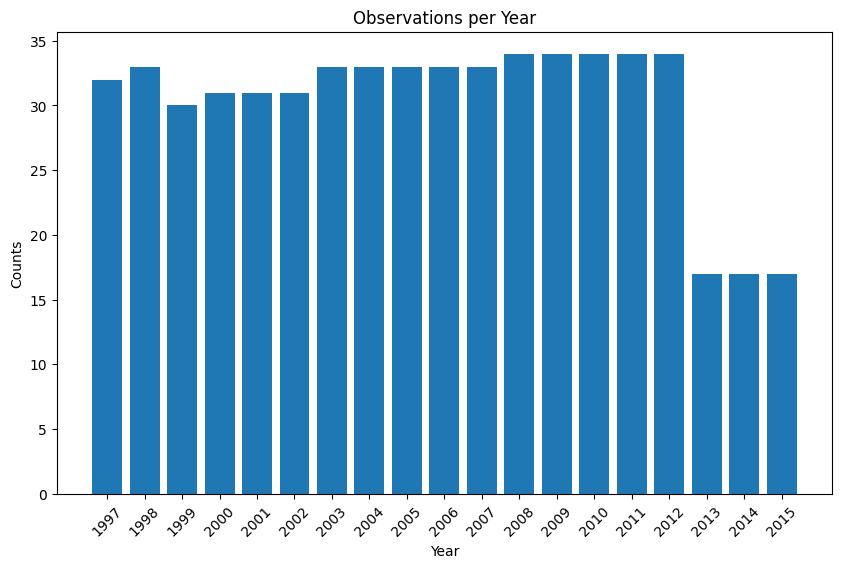

In [ ]:
# Plot count per year on bar plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts['year'], year_counts['counts'])
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Observations per Year')
plt.xticks(year_counts['year'], rotation=45)

plt.show()

In [ ]:
# Keep only years from 1997 to 2012
df_merged = df_merged.set_index(["country_name", "year"])
df_merged.sort_index(inplace=True)
idx = pd.IndexSlice
df_merged = df_merged.loc[idx[:, 1997:2012], :]
df_merged.describe()

,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity,women_voting_right_year,years_since_suffrage,quota
count,523.000000,523.000000,5.230000e+02,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,21.341739,1.729290,1.696661e+06,73.741231,8.205725,9.821985,1.775510,8.829828,1928.835564,75.803059,0.122371
std,11.103960,0.449325,5.637839e+06,37.197138,4.093522,2.167507,0.954811,3.127512,15.550675,16.186575,0.328027
min,2.363636,1.085000,7.646798e+03,16.438585,0.817360,3.200000,0.375000,-7.000000,1902.000000,26.000000,0.000000
25%,12.048193,1.370000,2.810656e+04,49.609487,5.755476,8.525000,0.854167,9.000000,1918.000000,63.000000,0.000000
50%,19.659443,1.650000,4.104951e+04,62.223797,7.943859,10.466000,1.729167,10.000000,1920.000000,80.000000,0.000000
75%,29.824561,1.923000,3.157863e+05,90.076255,10.210390,11.440000,2.543750,10.000000,1945.000000,88.000000,0.000000
max,47.277937,3.514000,3.088083e+07,191.880382,20.330853,13.230000,4.133333,10.000000,1971.000000,110.000000,1.000000


In [ ]:
# Count number of observations by country
country_counts = df_merged.groupby(['country_name']).size().reset_index(name='counts')
df_country_counts = country_counts.groupby('country_name')['counts'].sum().reset_index()
df_country_counts


,country_name,counts
0,Australia,15
1,Austria,14
2,Belgium,16
3,Brazil,16
4,Canada,15
5,China,15
6,Czechia,16
7,Denmark,15
8,Finland,16
9,France,16


In [ ]:
# Drop Slovenia, which is an outlier
df_merged = df_merged.reset_index()
df_merged = df_merged[df_merged['country_name'] != 'Slovenia']
country_counts = df_merged.groupby(['country_name']).size().reset_index(name='counts')
df_country_counts = country_counts.groupby('country_name')['counts'].sum().reset_index()
df_country_counts

,country_name,counts
0,Australia,15
1,Austria,14
2,Belgium,16
3,Brazil,16
4,Canada,15
5,China,15
6,Czechia,16
7,Denmark,15
8,Finland,16
9,France,16


In [ ]:
# Plot counts per country on world map
map_gps = px.choropleth(
    df_country_counts,                                 # dataframe as argument
    locations="country_name",                       # column name with location
    locationmode="country names",                          # Correct location method
    color="counts",                       # color countries with women_seats value
    color_continuous_scale=px.colors.sequential.Blues,   # choice of colors
    hover_name="country_name",  # Show country name on hover
    hover_data={"country_name": False, "counts": True},  # Hide redundant info in tooltip
    template="plotly_white"  # Cleaner template
)

map_gps.update_layout(
    title_text="Observations per Country",
    title_x=0.5,
    title_y=0.95,
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    ),
    coloraxis_colorbar=dict(
        title="Count",  # Title for color bar
        tickvals=[df_country_counts['counts'].min(), df_country_counts['counts'].max()],  # Specific tick values
        tickformat=",.0f"  # Formatting for tick labels
    )
)

map_gps.show()

### 5.5) Overview of Merged Database

In [ ]:
df_merged.describe()

,year,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity,women_voting_right_year,years_since_suffrage,quota
count,518.000000,518.000000,518.000000,5.180000e+02,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,2004.586873,21.341820,1.730982,1.712857e+06,73.184665,8.209846,9.802355,1.772096,8.818533,1928.679537,75.907336,0.113900
std,4.610893,11.123143,0.451155,5.662609e+06,36.925514,4.112843,2.168665,0.958241,3.140471,15.543836,16.228992,0.317996
min,1997.000000,2.363636,1.085000,7.646798e+03,16.438585,0.817360,3.200000,0.375000,-7.000000,1902.000000,26.000000,0.000000
25%,2001.000000,12.048193,1.370000,2.853587e+04,49.584058,5.744393,8.505000,0.854167,9.000000,1918.000000,62.250000,0.000000
50%,2005.000000,19.659443,1.669000,4.136748e+04,62.177875,7.968186,10.459000,1.710417,10.000000,1920.000000,80.000000,0.000000
75%,2009.000000,29.824561,1.926750,3.186739e+05,89.241248,10.222325,11.400000,2.552083,10.000000,1945.000000,88.000000,0.000000
max,2012.000000,47.277937,3.514000,3.088083e+07,191.880382,20.330853,13.230000,4.133333,10.000000,1971.000000,110.000000,1.000000


In [ ]:
df_merged.head()

,country_name,year,country_code,women_seats,fertility_rate,gdp,openness,co2,education,stringency_index,polity,women_voting_right_year,years_since_suffrage,quota
0,Australia,1997,AUS,15.540541,1.778,60992.006910,37.980832,16.706176,11.068,0.458333,10.0,1902.0,95.0,0.0
1,Australia,1998,AUS,15.540541,1.762,63203.100413,39.992702,17.602334,11.052,0.770833,10.0,1902.0,96.0,0.0
2,Australia,1999,AUS,22.448980,1.755,65658.498095,39.029795,17.737243,11.036,1.020833,10.0,1902.0,97.0,0.0
3,Australia,2000,AUS,22.972973,1.756,67456.847783,40.935211,17.837318,11.020,0.979167,10.0,1902.0,98.0,0.0
4,Australia,2002,AUS,25.333333,1.756,69849.773355,41.449092,18.123211,11.160,1.212500,10.0,1902.0,100.0,0.0


#Univariate Analyses 🔍

## <h3>Analysis Functions</h3>

In [ ]:
# Defining functions for univariate analyses

# Function for calculating statistical metrics
def calculate_statistics(df, column):
    mean_value = df[column].mean()
    median_value = df[column].median()
    variance_value = df[column].var()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = max(Q1 - 1.5 * IQR, 0)
    upper_whisker = Q3 + 1.5 * IQR
    outliers_count = ((df[column] < lower_whisker) | (df[column] > upper_whisker)).sum()
    return mean_value, median_value, variance_value, Q1, Q3, lower_whisker, upper_whisker, outliers_count

# Function for drawing a boxplot
def draw_boxplot(df, column, title, xlabel, is_percentage=False):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(title)
    plt.xlabel(xlabel)

    stats = calculate_statistics(df, column)
    percent_sign = "%" if is_percentage else ""

    plt.axvline(x=stats[0], color='yellow', linestyle='--', label=f'Mean: {stats[0]:.2f}{percent_sign}')
    plt.axvline(x=stats[1], color='green', linestyle='--', label=f'Median: {stats[1]:.2f}{percent_sign}')
    plt.axvline(x=stats[3], color='blue', linestyle='--', label=f'Q1: {stats[3]:.2f}{percent_sign}')
    plt.axvline(x=stats[4], color='red', linestyle='--', label=f'Q3: {stats[4]:.2f}{percent_sign}')
    plt.axvline(x=stats[5], color='purple', linestyle=':', label=f'Lower Whisker: {max(stats[5], 0):.2f}{percent_sign}')
    plt.axvline(x=stats[6], color='orange', linestyle=':', label=f'Upper Whisker: {stats[6]:.2f}{percent_sign}')
    plt.legend()
    plt.show()

# Function for drawing a histogram
def draw_histogram(df, column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=10, kde=True, color="dodgerblue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')

    skewness_value = skew(df[column], nan_policy='omit')
    plt.annotate(f"Skewness: {skewness_value:.2f}", xy=(0.7, 0.9), xycoords="axes fraction", fontsize=12)
    plt.show()

# Function for creating an interactive map
def create_interactive_map(df, column, country_col, title):
    df_map = df.groupby([country_col])[column].mean().reset_index()
    fig = px.choropleth(
        df_map,
        locations=country_col,
        locationmode='country names',
        color=column,
        hover_name=country_col,
        color_continuous_scale=px.colors.sequential.Blues
    )
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        geo=dict(showframe=False, projection_type='equirectangular', landcolor='lightgray', countrycolor='darkgray')
    )
    fig.show()

# Function for creating line graphs
def create_mean_line_graphs(df, time_col, data_col, country_col, title_avg, title_country, is_percentage=False):
    # Grouping by the time column and computing the mean of the data column
    mean_per_time = df.groupby(time_col)[data_col].mean().reset_index()
    percent_sign = "%" if is_percentage else ""

    # Creating the line graph for the average values over time
    fig1 = px.line(
        mean_per_time,
        x=time_col,
        y=data_col,
        title=title_avg
    )
    fig1.update_layout(width=800, height=400)
    fig1.update_xaxes(title_text=time_col)
    fig1.update_yaxes(title_text=f'{data_col} {percent_sign}')

    # Creating the line graph for the data column trends for each country over time
    fig2 = px.line(
        df,
        x=time_col,
        y=data_col,
        color=country_col,
        title=title_country
    )
    fig2.update_layout(width=800, height=400)
    fig2.update_xaxes(title_text='Year')
    fig2.update_yaxes(title_text=f'{data_col} {percent_sign}')

    fig1.show()
    fig2.show()

##<h3>Independent Variable: Women Seats in Parliaments</h3>

In [ ]:
df_merged['women_seats'].describe()

count    518.000000
mean      21.341820
std       11.123143
min        2.363636
25%       12.048193
50%       19.659443
75%       29.824561
max       47.277937
Name: women_seats, dtype: float64

In [ ]:
# Calculate statistics for 'women_seats'
calculate_statistics(df_merged, 'women_seats')

(21.341819730877056,
 19.6594427244582,
 123.72430628461908,
 12.0481927710843,
 29.8245614035088,
 0,
 56.48911435214555,
 0)

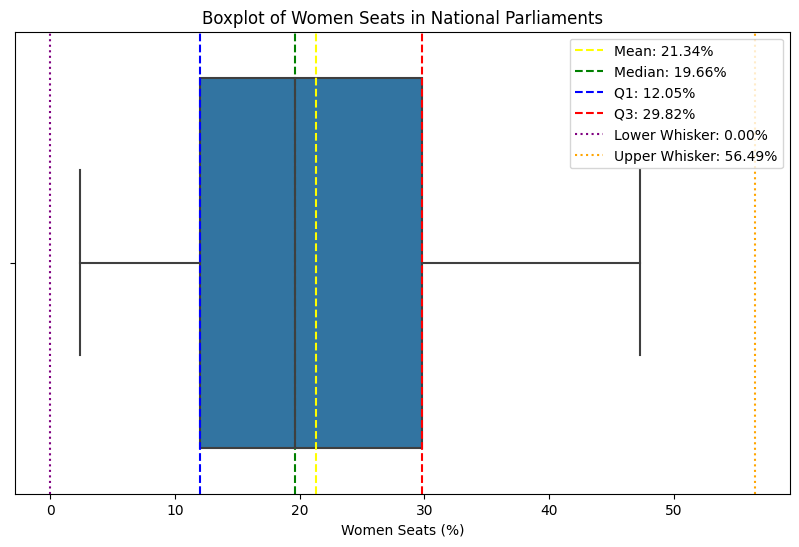

In [ ]:
# Draw a boxplot for 'women_seats'
draw_boxplot(df_merged, 'women_seats', 'Boxplot of Women Seats in National Parliaments', 'Women Seats (%)', is_percentage=True)

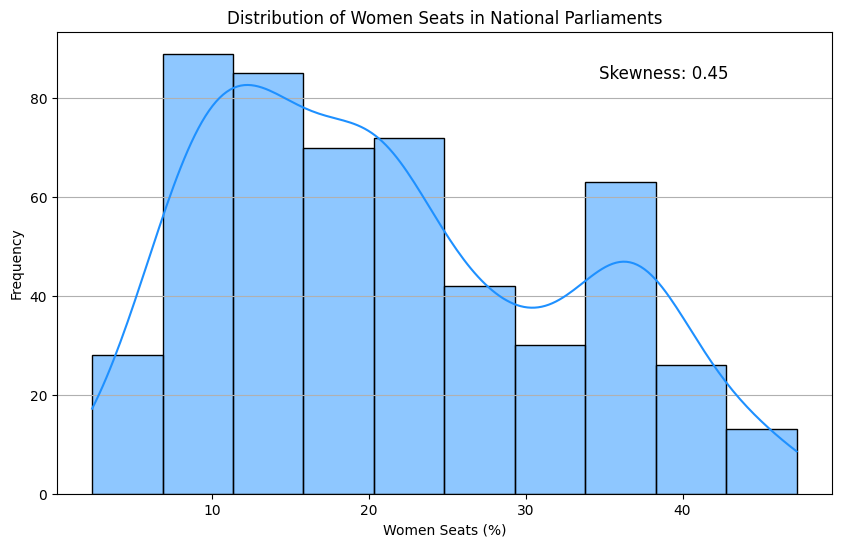

In [ ]:
# Draw a histogram for 'women_seats'
draw_histogram(df_merged, 'women_seats', 'Distribution of Women Seats in National Parliaments', 'Women Seats (%)', 'Frequency')

In [ ]:
# Create an interactive map for 'women_seats'
create_interactive_map(df_merged, 'women_seats', 'country_name', 'Average Women Seats in National Parliaments by Country')

In [ ]:
# Create line graphs for 'women_seats'
create_mean_line_graphs(df_merged.reset_index(),'year','women_seats','country_name',"Average Women Seats in National Parliaments Over Time","Proportion of Seats Held by Women in National Parliaments Over Time by Country", is_percentage=True)

## <h3>Dependent Variable: Environmental Policies Stringency Index</h3>

In [ ]:
# Describing the variable
df_merged['stringency_index'].describe()

count    518.000000
mean       1.772096
std        0.958241
min        0.375000
25%        0.854167
50%        1.710417
75%        2.552083
max        4.133333
Name: stringency_index, dtype: float64

In [ ]:
# Calculate Statistics for 'stringency_index'
calculate_statistics(df_merged, 'stringency_index')

(1.772096202870594,
 1.71041667461395,
 0.9182265979342856,
 0.85416662693024,
 2.552083432674375,
 0,
 5.098958641290578,
 0)

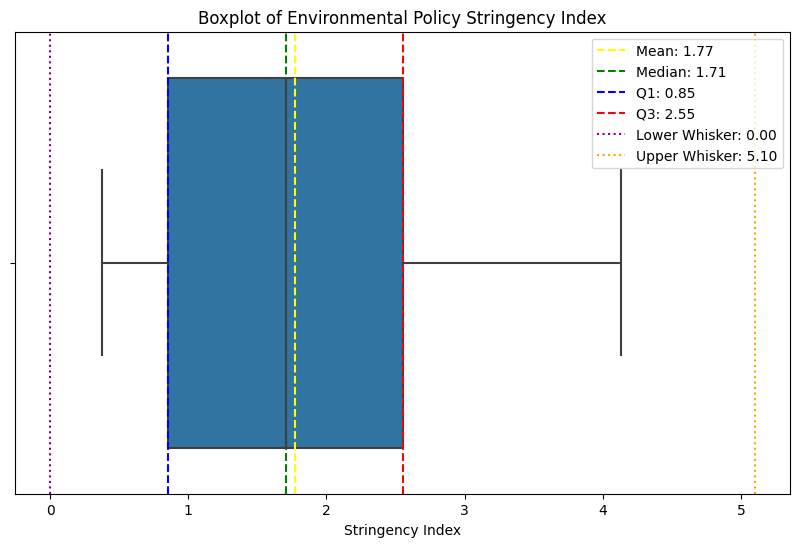

In [ ]:
# Draw a Boxplot for 'stringency_index':
draw_boxplot(df_merged, 'stringency_index', 'Boxplot of Environmental Policy Stringency Index', 'Stringency Index')

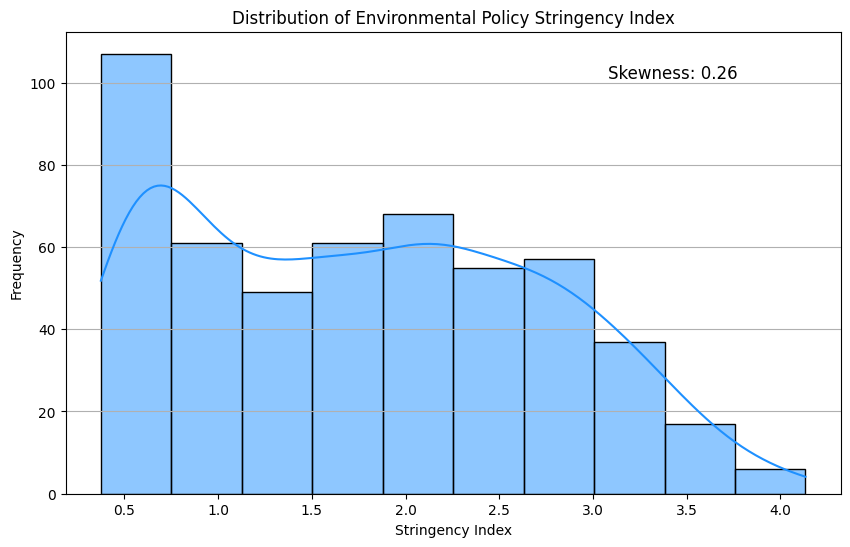

In [ ]:
# Draw a Histogram for 'stringency_index':
draw_histogram(df_merged, 'stringency_index', 'Distribution of Environmental Policy Stringency Index', 'Stringency Index', 'Frequency')

In [ ]:
# Create an Interactive Map
create_interactive_map(df_merged, 'stringency_index', 'country_name', 'Average Environmental Policy Stringency Index by Country')


In [ ]:
# Create Line Graphs for 'stringency_index'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'stringency_index', 'country_name', "Average Environmental Policy Stringency Index Over Time", "Environmental Policy Stringency Index Over Time by Country")

## <h3>Heterogeneity Variable: Fertility Rate</h3>

In [ ]:
df_merged['fertility_rate'].describe()

count    518.000000
mean       1.730982
std        0.451155
min        1.085000
25%        1.370000
50%        1.669000
75%        1.926750
max        3.514000
Name: fertility_rate, dtype: float64

In [ ]:
# Calculate Statistics for 'fertility_rate'
calculate_statistics(df_merged, 'fertility_rate')

(1.7309816602316603,
 1.669,
 0.2035412428931764,
 1.37,
 1.92675,
 0.5348750000000003,
 2.761875,
 14)

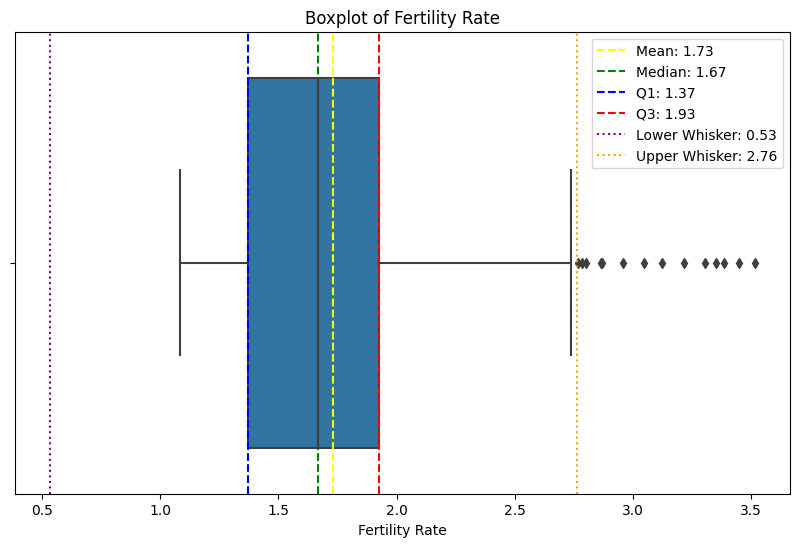

In [ ]:
# Draw a Boxplot for 'fertility_rate'
draw_boxplot(df_merged, 'fertility_rate', 'Boxplot of Fertility Rate', 'Fertility Rate')

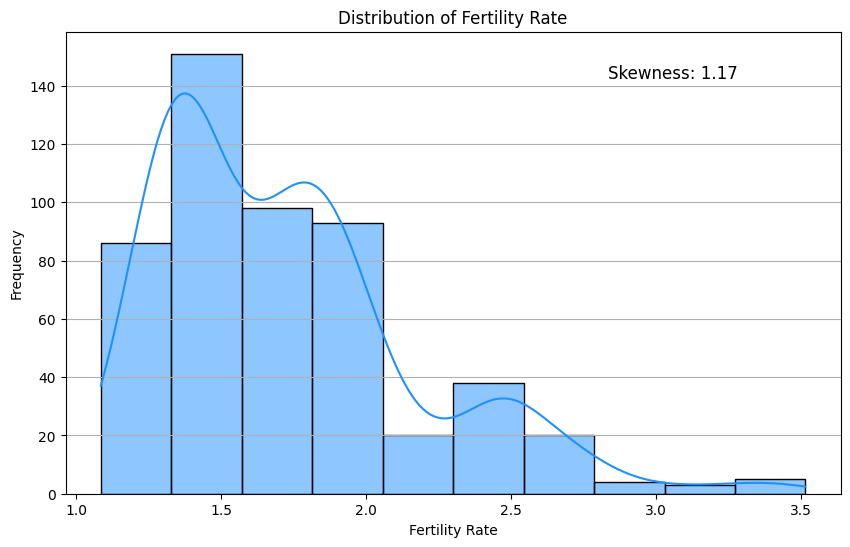

In [ ]:
# Draw a Histogram for 'fertility_rate'
draw_histogram(df_merged, 'fertility_rate', 'Distribution of Fertility Rate', 'Fertility Rate', 'Frequency')

In [ ]:
# Create an Interactive Map for 'fertility_rate'
create_interactive_map(df_merged, 'fertility_rate', 'country_name', 'Average Fertility Rate by Country')

In [ ]:
# Create Line Graphs for 'fertility_rate'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'fertility_rate', 'country_name', "Average Fertility Rate Over Time", "Fertility Rate Over Time by Country")

## <h3>Control 1: GDP per Capita + Log Transformation</h3>

###<h4>Before log transformation

In [ ]:
# Get an overview of 'gdp'
df_merged['gdp'].describe()

count    5.180000e+02
mean     1.712857e+06
std      5.662609e+06
min      7.646798e+03
25%      2.853587e+04
50%      4.136748e+04
75%      3.186739e+05
max      3.088083e+07
Name: gdp, dtype: float64

In [ ]:
# Calculate Statistics for 'gdp'
calculate_statistics(df_merged, 'gdp')

(1712856.7596144276,
 41367.4769370782,
 32065138567254.383,
 28535.8669187549,
 318673.854637933,
 0,
 753880.8362167003,
 63)

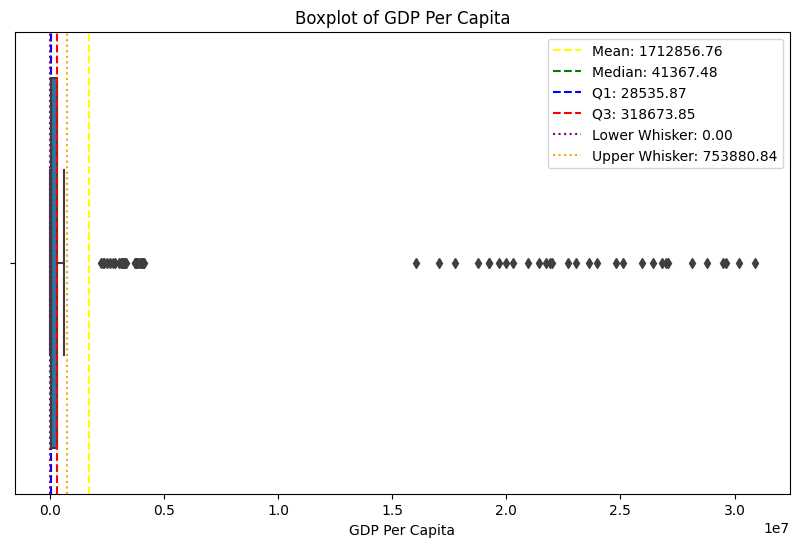

In [ ]:
# Draw a Boxplot for 'gdp'
draw_boxplot(df_merged, 'gdp', 'Boxplot of GDP Per Capita', 'GDP Per Capita')

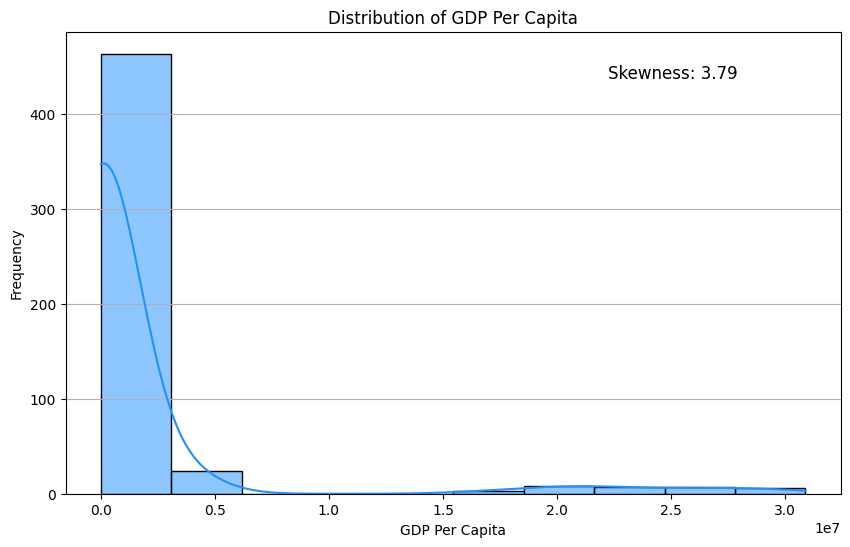

In [ ]:
# Draw a Histogram for 'gdp'
draw_histogram(df_merged, 'gdp', 'Distribution of GDP Per Capita', 'GDP Per Capita', 'Frequency')

In [ ]:
# Create an Interactive Map for 'gdp'
create_interactive_map(df_merged, 'gdp', 'country_name', 'Average GDP Per Capita by Country')

In [ ]:
# Create Line Graphs for 'gdp'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'gdp', 'country_name', "Average GDP Per Capita Over Time", "GDP Per Capita Over Time by Country")

###<h4>After log transformation

In [ ]:
# Applying logarithmic transformation to the 'gdp' column
df_merged['log_gdp'] = np.log(df_merged['gdp'])

# Displaying the first few rows to verify the transformation
df_merged[['gdp', 'log_gdp']].head()

,gdp,log_gdp
0,60992.006910,11.018498
1,63203.100413,11.054109
2,65658.498095,11.092222
3,67456.847783,11.119243
4,69849.773355,11.154102


In [ ]:
# Get an overview of 'log_gdp'
df_merged['log_gdp'].describe()

count    518.000000
mean      11.478919
std        1.999151
min        8.942042
25%       10.258916
50%       10.630250
75%       12.671923
max       17.245646
Name: log_gdp, dtype: float64

In [ ]:
# Calculate Statistics for 'log_gdp'
calculate_statistics(df_merged, 'log_gdp')

(11.478918696284332,
 10.630249863060143,
 3.996603917326155,
 10.258915911234501,
 12.671923241507196,
 6.639404915825459,
 16.29143423691624,
 31)

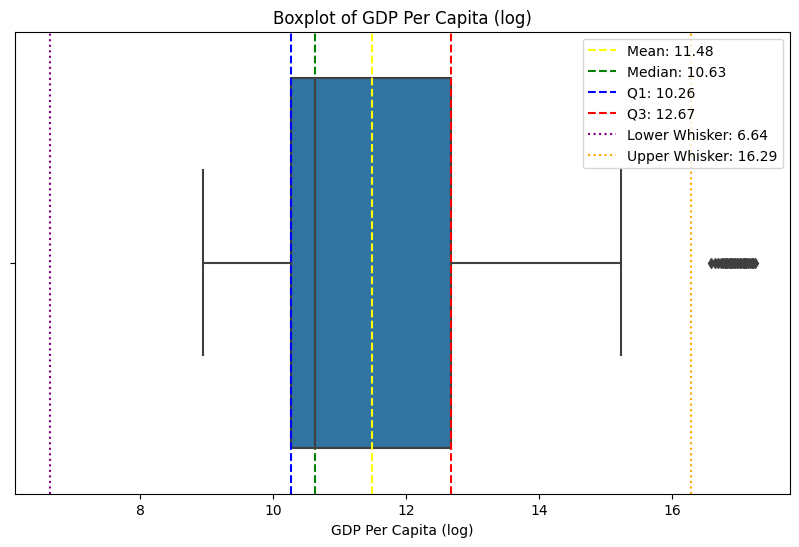

In [ ]:
# Draw a Boxplot for 'log_gdp'
draw_boxplot(df_merged, 'log_gdp', 'Boxplot of GDP Per Capita (log)', 'GDP Per Capita (log)')

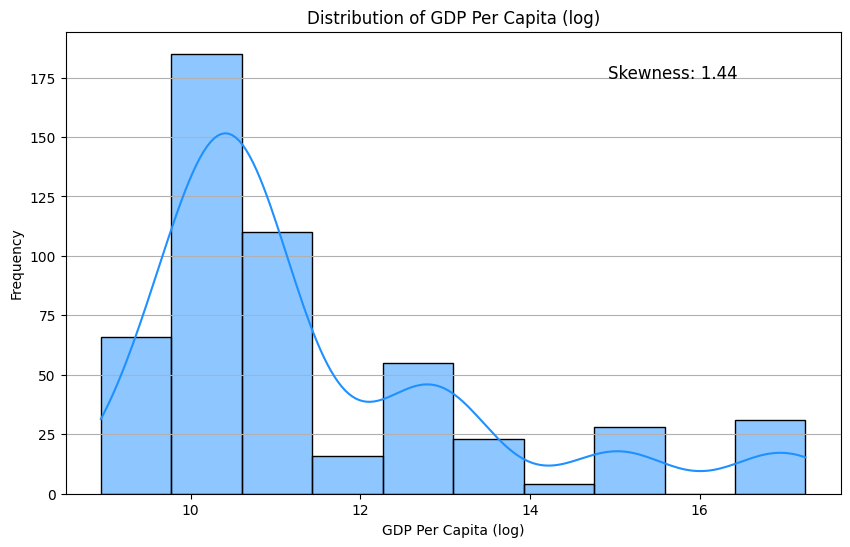

In [ ]:
# Draw a Histogram for 'log_gdp'
draw_histogram(df_merged, 'log_gdp', 'Distribution of GDP Per Capita (log)', 'GDP Per Capita (log)', 'Frequency')

## <h3>Control 2: Trade Openness</h3>

In [ ]:
# Get an overview of 'openness'
df_merged['openness'].describe()

count    518.000000
mean      73.184665
std       36.925514
min       16.438585
25%       49.584058
50%       62.177875
75%       89.241248
max      191.880382
Name: openness, dtype: float64

In [ ]:
# Calculate Statistics for 'openness'
calculate_statistics(df_merged, 'openness')

(73.18466527767238,
 62.17787538043075,
 1363.4935704625696,
 49.58405755641705,
 89.24124847591418,
 0,
 148.72703485515987,
 31)

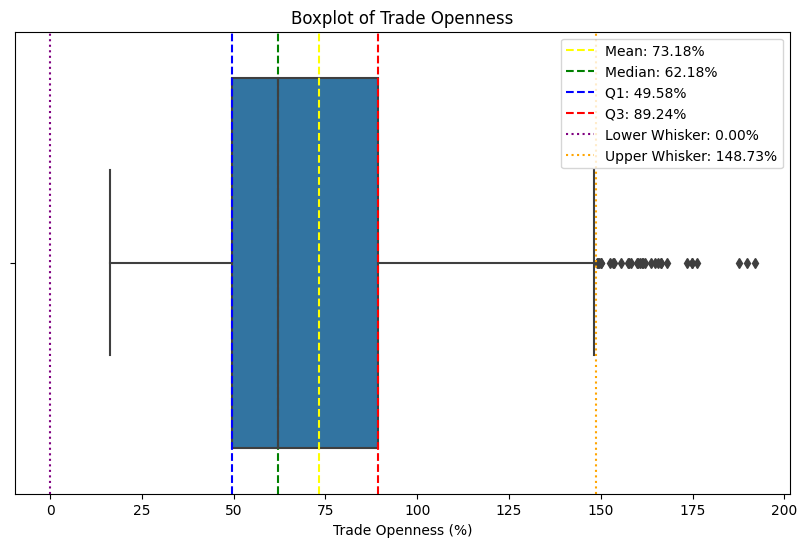

In [ ]:
# Draw a Boxplot for 'openness'
draw_boxplot(df_merged, 'openness', 'Boxplot of Trade Openness', 'Trade Openness (%)', is_percentage=True)

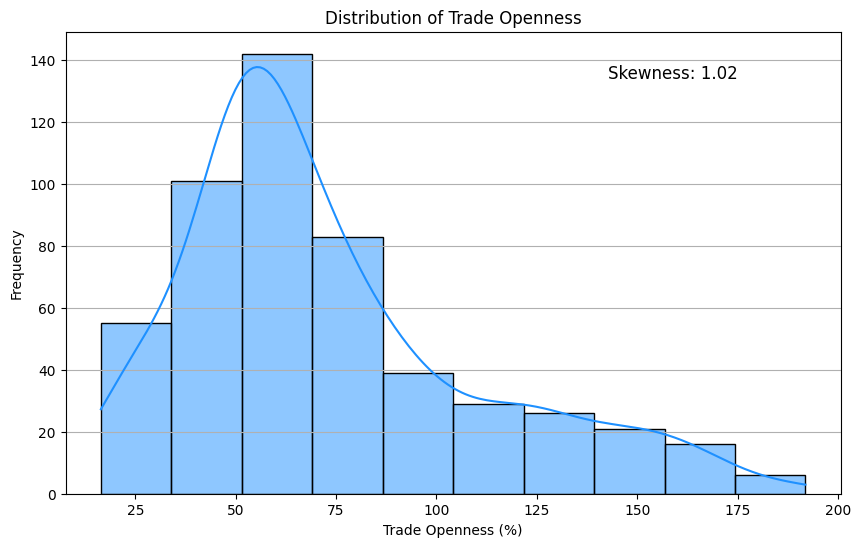

In [ ]:
# Draw a Histogram for 'openness'
draw_histogram(df_merged, 'openness', 'Distribution of Trade Openness', 'Trade Openness (%)', 'Frequency')

In [ ]:
# Create an Interactive Map for 'openness'
create_interactive_map(df_merged, 'openness', 'country_name', 'Average Trade Openness by Country')

In [ ]:
# Create Line Graphs for 'openness'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'openness', 'country_name', "Average Trade Openness Over Time", "Trade Openness Over Time by Country", is_percentage=True)

##<h3>Control 3: CO2 Emissions per Capita</h3>

In [ ]:
# Get an overview of 'co2'
df_merged['co2'].describe()

count    518.000000
mean       8.209846
std        4.112843
min        0.817360
25%        5.744393
50%        7.968186
75%       10.222325
max       20.330853
Name: co2, dtype: float64

In [ ]:
# Calculate Statistics for 'co2'
calculate_statistics(df_merged, 'co2')

(8.209846068514194,
 7.968186116521995,
 16.915476538220908,
 5.744393400953729,
 10.222325268175801,
 0,
 16.93922306900891,
 29)

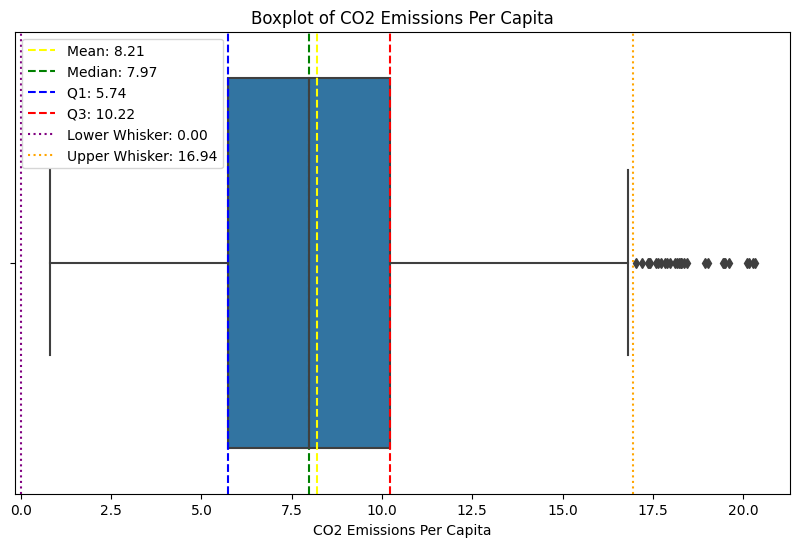

In [ ]:
# Draw a Boxplot for 'co2'
draw_boxplot(df_merged, 'co2', 'Boxplot of CO2 Emissions Per Capita', 'CO2 Emissions Per Capita')

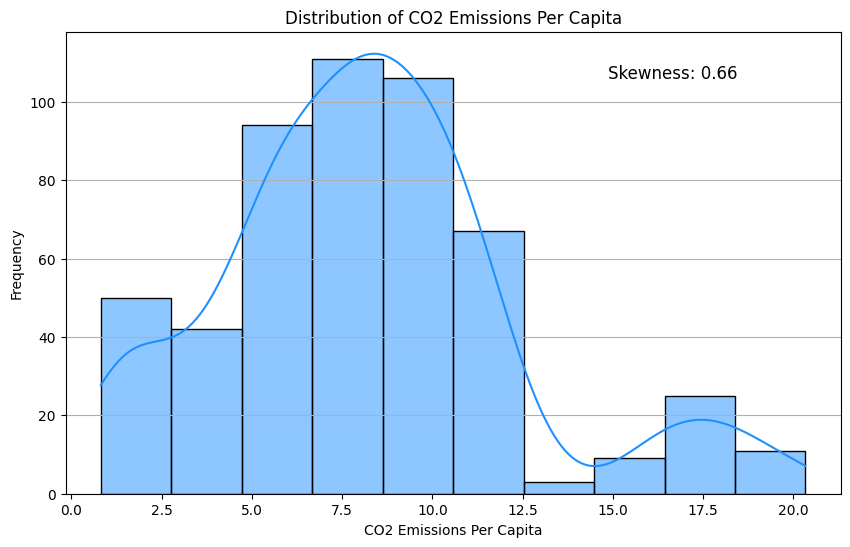

In [ ]:
# Draw a Histogram for 'co2'
draw_histogram(df_merged, 'co2', 'Distribution of CO2 Emissions Per Capita', 'CO2 Emissions Per Capita', 'Frequency')

In [ ]:
# Create an Interactive Map for 'co2'
create_interactive_map(df_merged, 'co2', 'country_name', 'Average CO2 Emissions Per Capita by Country')

In [ ]:
# Create Line Graphs for 'co2'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'co2', 'country_name', "Average CO2 Emissions Per Capita Over Time", "CO2 Emissions Per Capita Over Time by Country")

##<h3>Control 4: Polity Index (Democracy Level)</h3>

In [ ]:
# Get an overview of 'polity'
df_merged['polity'].describe()

count    518.000000
mean       8.818533
std        3.140471
min       -7.000000
25%        9.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: polity, dtype: float64

In [ ]:
# Calculate Statistics for 'polity'
calculate_statistics(df_merged, 'polity')

(8.818532818532818, 10.0, 9.86255722425935, 9.0, 10.0, 7.5, 11.5, 54)

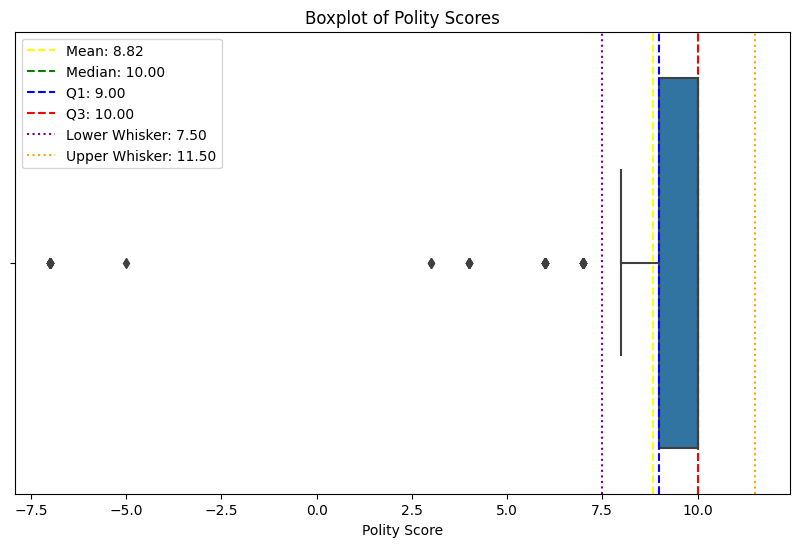

In [ ]:
# Draw a Boxplot for 'polity'
draw_boxplot(df_merged, 'polity', 'Boxplot of Polity Scores', 'Polity Score')

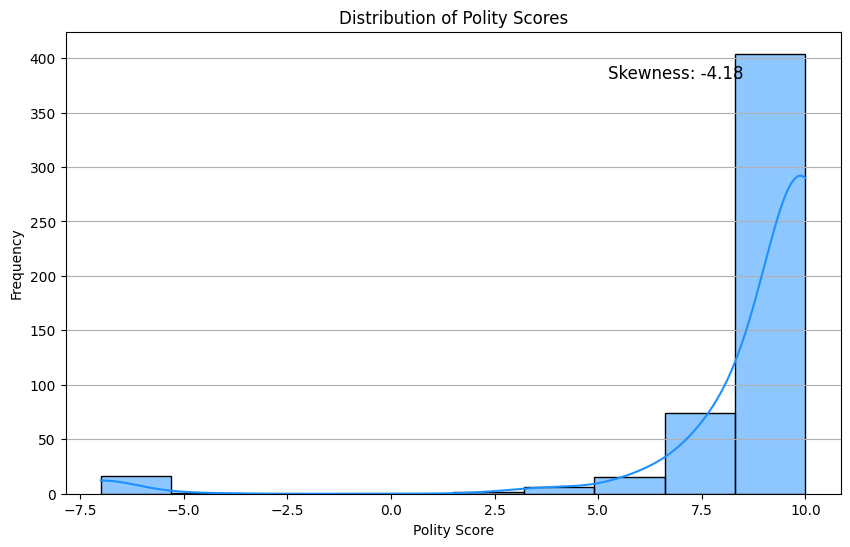

In [ ]:
# Draw a Histogram for 'polity'
draw_histogram(df_merged, 'polity', 'Distribution of Polity Scores', 'Polity Score', 'Frequency')

In [ ]:
# Create an Interactive Map for 'polity'
create_interactive_map(df_merged, 'polity', 'country_name', 'Average Polity Score by Country')

In [ ]:
# Create Line Graphs for 'polity'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'polity', 'country_name', "Average Polity Score Over Time", "Polity Score Over Time by Country")

##<h3>Control 5: Education (Average Schooling Years)</h3>

In [ ]:
# Get an overview of 'education'
df_merged['education'].describe()

count    518.000000
mean       9.802355
std        2.168665
min        3.200000
25%        8.505000
50%       10.459000
75%       11.400000
max       13.230000
Name: education, dtype: float64

In [ ]:
# Calculate Statistics for 'education'
calculate_statistics(df_merged, 'education')

(9.802355212355215,
 10.459,
 4.703107138570458,
 8.504999999999999,
 11.4,
 4.162499999999997,
 15.742500000000003,
 9)

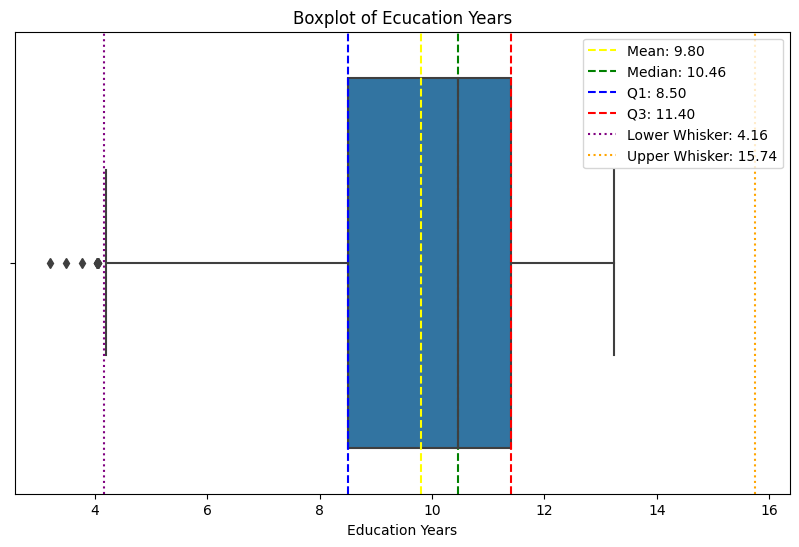

In [ ]:
# Draw a Boxplot for 'education'
draw_boxplot(df_merged, 'education', 'Boxplot of Ecucation Years', 'Education Years')

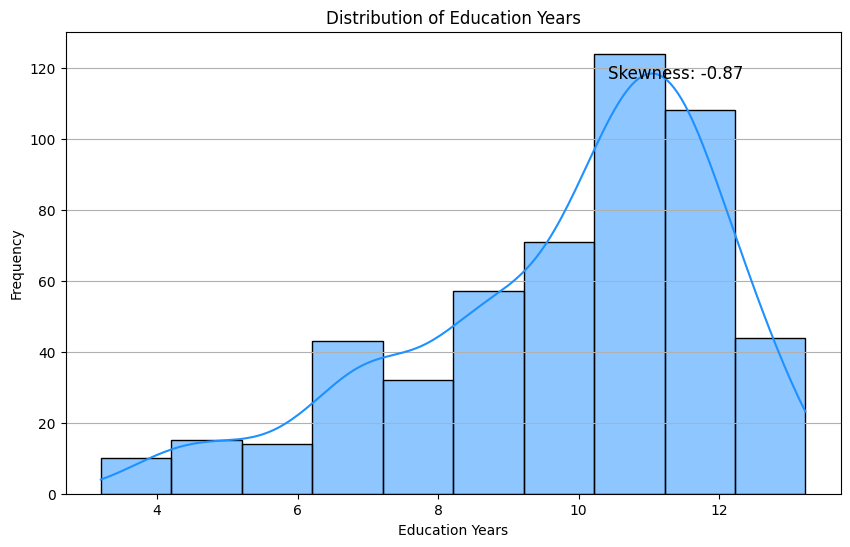

In [ ]:
# Draw a Histogram for 'education'
draw_histogram(df_merged, 'education', 'Distribution of Education Years', 'Education Years', 'Frequency')

In [ ]:
# Create an Interactive Map for 'education'
create_interactive_map(df_merged, 'education', 'country_name', 'Average Education Years by Country')

In [ ]:
# Create Line Graphs for 'education'
create_mean_line_graphs(df_merged.reset_index(), 'year', 'education', 'country_name', "Average Education Years Over Time", "Education Years Over Time by Country")

##<h3>Downloading Final Database</h3>

In [ ]:
df_merged.head()

index country_code  women_seats  fertility_rate  \
country_name year                                                    
Australia    1997      0          AUS    15.540541           1.778   
             1998      1          AUS    15.540541           1.762   
             1999      2          AUS    22.448980           1.755   
             2000      3          AUS    22.972973           1.756   
             2002      4          AUS    25.333333           1.756   

                            gdp   openness        co2  education  \
country_name year                                                  
Australia    1997  60992.006910  37.980832  16.706176     11.068   
             1998  63203.100413  39.992702  17.602334     11.052   
             1999  65658.498095  39.029795  17.737243     11.036   
             2000  67456.847783  40.935211  17.837318     11.020   
             2002  69849.773355  41.449092  18.123211     11.160   

                   stringency_index  polity  ...    log_gdp  \
country_name year                            ...              
Australia    1997          0.458333    10.0  ...  11.018498   
             1998          0.770833    10.0  ...  11.054109   
             1999          1.020833    10.0  ...  11.092222   
             2000          0.979167    10.0  ...  11.119243   
             2002          1.212500    10.0  ...  11.154102   

                   normalized_polity  reflected_normalized_polity  \
country_name year                                                   
Australia    1997                1.0                          0.1   
             1998                1.0                          0.1   
             1999                1.0                          0.1   
             2000                1.0                          0.1   
             2002                1.0                          0.1   

                   log_reflected_normalized_polity  fertility_group  \
country_name year                                                     
Australia    1997                        -2.207275     Above Median   
             1998                        -2.207275     Above Median   
             1999                        -2.207275     Above Median   
             2000                        -2.207275     Above Median   
             2002                        -2.207275     Above Median   

                   Years_Since_Suffrage_category  Polity_Category  \
country_name year                                                   
Australia    1997                           high             High   
             1998                           high             High   
             1999                           high             High   
             2000                           high             High   
             2002                           high             High   

                  GDP_Category Education_Category Women_Category  
country_name year                                                 
Australia    1997         High               High            Low  
             1998         High               High            Low  
             1999         High               High           High  
             2000         High               High           High  
             2002         High               High           High  

[5 rows x 23 columns]

In [ ]:
# Reset index for easier download
#df_download = df_merged.reset_index()
from google.colab import files
file_path = "merged_data_final.xlsx"
df_merged.to_excel(file_path, index=True)
# Download the file to your local machine
#UNCOMMENT BELOW FOR DOWNLOAD
#files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Bivariate Analysis 🖇



## <h3>Correlation</h3>

We can start by checking the correlation between the proportion of women and the ennvironmental index

In [ ]:
women_index_corr = df_merged.loc[:,'stringency_index':'women_seats'].corr()
women_index_corr

""


## <h3>Heat map</h3>

Let's now do a heat map to have a more visual representation

In [ ]:
heatmap_corr = px.imshow(
    women_index_corr.values.round(2),         # correlation matrix values, rounded at 2 decimals
    x=list(women_index_corr.columns),         # label x-axis
    y=list(women_index_corr.index),           # label y-axis
    text_auto=True,                   # add values to the graph
    aspect="auto"                     # automatically adjust aspect (without the option: square)
)
heatmap_corr.update_xaxes(side="top")   # display labels on top (by default: bottom)
heatmap_corr.show()

## <h3>Scatter plot</h3>

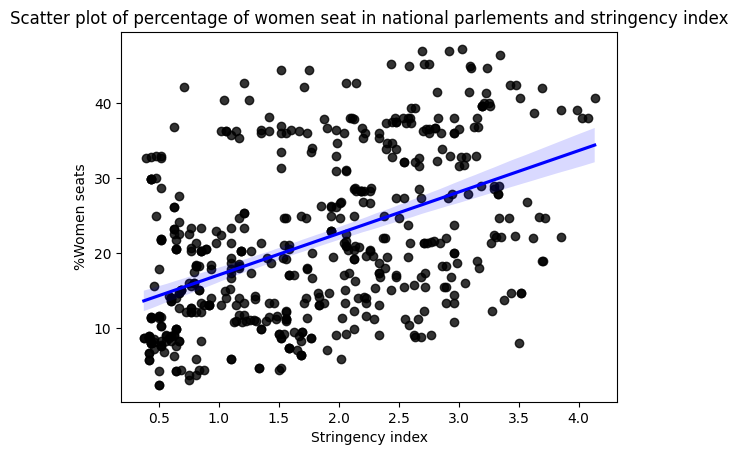

In [ ]:
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter_kws={'color': 'black'},  # Paramètres du scatter plot
            line_kws={'color': 'blue'}        # Paramètres de la ligne de régression
           )

plt.title("Scatter plot of percentage of women seat in national parlements and stringency index")
plt.xlabel("Stringency index")
plt.ylabel("%Women seats")
plt.show()


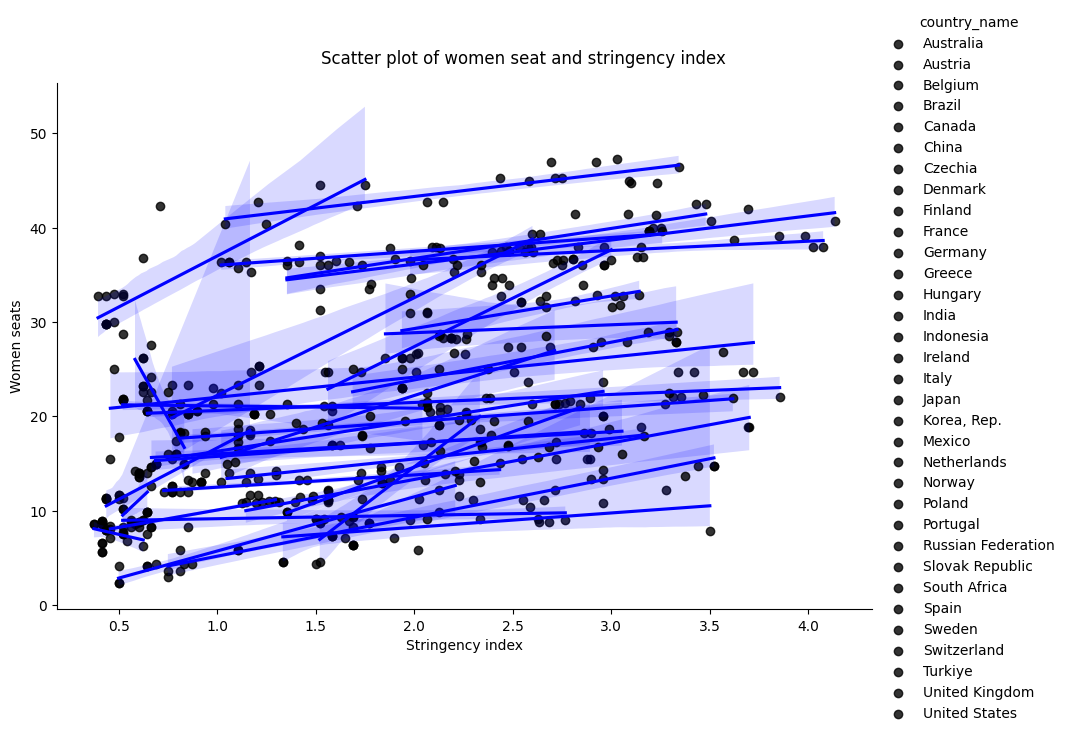

In [ ]:
lm = sns.lmplot(
    x='stringency_index',
    y='women_seats',
    data=df_merged,
    hue='country_name',            # Coloring by country
    scatter_kws={'color': 'black'},  # Overriding this to keep dots black, but they'll be colored by hue
    line_kws={'color': 'blue'},      # Regression line color
    height=6,
    aspect=1.5
)

lm.set_axis_labels("Stringency index", "Women seats")
lm.fig.suptitle("Scatter plot of women seat and stringency index", y=1.03)

plt.show()

Text(0, 0.5, '% Women seats')

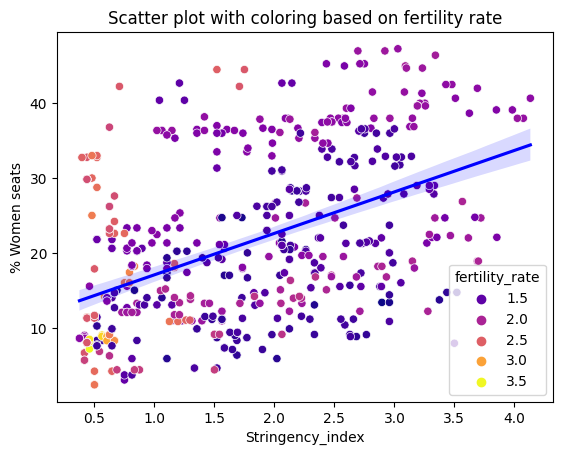

In [ ]:
#Scatter plot coloring the dots by fertility rate
scatter=sns.scatterplot(x='stringency_index', y='women_seats', legend=True, hue='fertility_rate', palette='plasma', data=df_merged)
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter=False,           # We don't want to plot points again
            color='blue')
plt.title("Scatter plot with coloring based on fertility rate")
plt.xlabel('Stringency_index')
plt.ylabel('% Women seats')

Text(0, 0.5, 'Women seats')

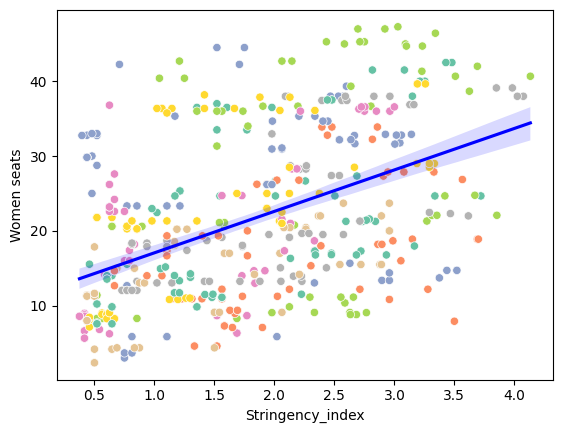

In [ ]:
#Scatter plot with coloring based on country
scatter=sns.scatterplot(x='stringency_index', y='women_seats', legend=False, hue='country_name', palette='Set2', data=df_merged)
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter=False,           # We don't want to plot points again
            color='blue')

plt.xlabel('Stringency_index')
plt.ylabel('Women seats')

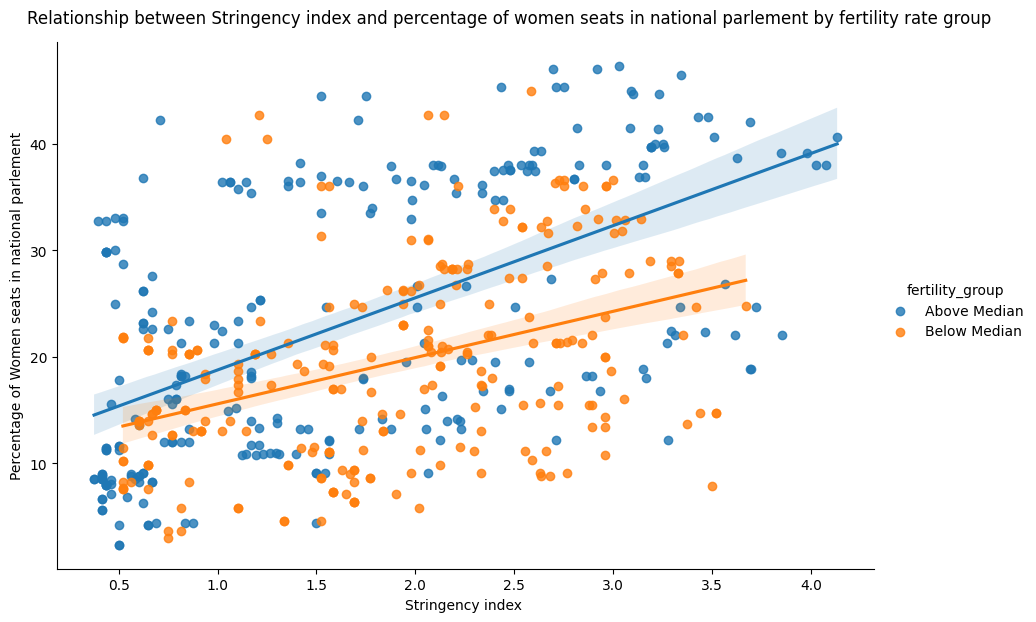

In [ ]:
# Calculate the median of fertility_rate
fertility_median = df_merged['fertility_rate'].median()

# Create a new column to indicate if fertility_rate is above or below the median
df_merged['fertility_group'] = ['Above Median' if x > fertility_median else 'Below Median'
                                               for x in df_merged['fertility_rate']]

# Plot the scatter plot with two regression lines using lmplot
lm = sns.lmplot(x='stringency_index',
                y='women_seats',
                hue='fertility_group',
                data=df_merged,
                height=6,
                aspect=1.5)

lm.set_axis_labels("Stringency index ", "Percentage of Women seats in national parlement")
lm.fig.suptitle("Relationship between Stringency index and percentage of women seats in national parlement by fertility rate group", y=1.03)

plt.show()

In [ ]:
# Filter the DataFrame for entries below the median and calculate the correlation
below_median_corr = df_merged[df_merged['fertility_group'] == 'Below Median']\
                        [['stringency_index', 'women_seats']].corr().iloc[0, 1]

# Filter the DataFrame for entries above the median and calculate the correlation
above_median_corr = df_merged[df_merged['fertility_group'] == 'Above Median']\
                        [['stringency_index', 'women_seats']].corr().iloc[0, 1]

below_median_corr, above_median_corr

(0.40173334572822117, 0.5682963007104702)

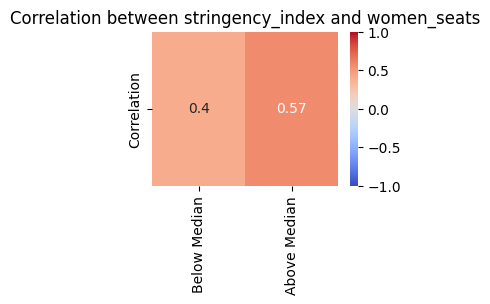

In [ ]:
# Create a DataFrame with correlation values
corr_data = pd.DataFrame({
    'Below Median': [below_median_corr],
    'Above Median': [above_median_corr]
}, index=['Correlation'])

# Display the heatmap using Seaborn
plt.figure(figsize=(3, 2))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation between stringency_index and women_seats")
plt.show()

## <h3>Pair Plot</h3>

In [ ]:
#sns.pairplot(df_merged.loc[:,'stringency_index':'women_seats'])      # dataframe as argument

#Regression Model (normal, fixed effect, 2SLS)

In [ ]:
# Création des modèles avec des contrôles progressifs
model1 = smf.ols('stringency_index ~ women_seats', data=df_merged).fit()
model2 = smf.ols('stringency_index ~ women_seats + log_gdp', data=df_merged).fit()
model3 = smf.ols('stringency_index ~ women_seats + log_gdp + polity', data=df_merged).fit()
model4 = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness', data=df_merged).fit()
model5 = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness + education', data=df_merged).fit()
model6 = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness + education + co2', data=df_merged).fit()

# Utilisation de Stargazer pour créer un tableau de régression
stargazer = Stargazer([model1, model2, model3, model4, model5, model6])

# Personnalisation et affichage du tableau
# Par exemple, pour changer le format des valeurs p, décommentez la ligne suivante :
# stargazer.significant_digits(3)
stargazer


To export the table in LaTex

In [ ]:
text_table = stargazer.render_latex()
with open("regression_table.tex", "w") as f:
    f.write(text_table)

from google.colab import files
files.download("regression_table.tex")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test of Robustness without outliers

In [ ]:
# Réinitialisation des indices du DataFrame
df_merged_reset = df_merged.reset_index(drop=True)

# Refaire le modèle avec les indices réinitialisés
model6 = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness + education + co2', data=df_merged_reset).fit()

dfbetas_model6 = model6.get_influence().dfbetas

n = len(df_merged)
threshold = 2 / np.sqrt(n)

# Identifier les indices des outliers
outlier_indices = np.any(np.abs(dfbetas_model6) > threshold, axis=1)

# Créer un nouveau DataFrame sans outliers
df_merged_no_outliers = df_merged[~outlier_indices].copy()

# Création des modèles avec des contrôles progressifs
model1_no_outliers = smf.ols('stringency_index ~ women_seats', data=df_merged_no_outliers).fit()
model2_no_outliers = smf.ols('stringency_index ~ women_seats + log_gdp', data=df_merged_no_outliers).fit()
model3_no_outliers = smf.ols('stringency_index ~ women_seats + log_gdp + polity', data=df_merged_no_outliers).fit()
model4_no_outliers = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness', data=df_merged_no_outliers).fit()
model5_no_outliers = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness + education', data=df_merged_no_outliers).fit()
model6_no_outliers = smf.ols('stringency_index ~ women_seats + log_gdp + polity + openness + education + co2', data=df_merged_no_outliers).fit()

# Utilisation de Stargazer pour créer un tableau de régression
stargazer = Stargazer([model1_no_outliers, model2_no_outliers, model3_no_outliers, model4_no_outliers, model5_no_outliers, model6_no_outliers])

# Personnalisation et affichage du tableau
# Par exemple, pour changer le format des valeurs p, décommentez la ligne suivante :
# stargazer.significant_digits(3)
stargazer

###Test de multicolinéarité

In [ ]:
# Ajout d'une constante au DataFrame pour le calcul du VIF
exog_vars = ['women_seats', 'log_gdp', 'polity', 'openness', 'education', 'co2']
df_with_constant = add_constant(df_merged[exog_vars])

# Calcul du VIF pour chaque variable explicative
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]
vif["features"] = df_with_constant.columns

print(vif)


   VIF Factor     features
0   52.958974        const
1    1.156649  women_seats
2    1.127321      log_gdp
3    1.195830       polity
4    1.366373     openness
5    2.970494    education
6    2.172894          co2


## Fixed Effect

### Year fixed effect

In [ ]:
df_merged.reset_index(inplace=True)
# Assurez-vous que 'year' et votre variable d'identification des individus (par exemple, 'country') sont définies comme index
df_merged= df_merged.set_index(['country_name', 'year'])

# Convertir toutes les variables nécessaires en float pour éviter les problèmes de type de données
df_merged['stringency_index'] = df_merged['stringency_index'].astype(float)
df_merged['women_seats'] = df_merged['women_seats'].astype(float)
df_merged['log_gdp'] = df_merged['log_gdp'].astype(float)
df_merged['polity'] = df_merged['polity'].astype(float)
df_merged['openness'] = df_merged['openness'].astype(float)
df_merged['education'] = df_merged['education'].astype(float)
df_merged['co2'] = df_merged['co2'].astype(float)

# Création du modèle avec effets fixes d'année
exog_vars = ['women_seats', 'log_gdp', 'polity', 'openness', 'education', 'co2']
exog = sm.add_constant(df_merged[exog_vars])
mod = PanelOLS(df_merged.stringency_index, exog, time_effects=True) # entity_effects=True ajoute des effets fixes d'entité
fe_res = mod.fit()

# Affichage des résultats
print(fe_res)


                          PanelOLS Estimation Summary                           
Dep. Variable:       stringency_index   R-squared:                        0.3773
Estimator:                   PanelOLS   R-squared (Between):              0.5280
No. Observations:                 518   R-squared (Within):               0.2165
Date:                Fri, Dec 22 2023   R-squared (Overall):              0.3690
Time:                        01:06:50   Log-likelihood                   -483.45
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      50.092
Entities:                          33   P-value                           0.0000
Avg Obs:                       15.697   Distribution:                   F(6,496)
Min Obs:                       14.000                                           
Max Obs:                       16.000   F-statistic (robust):             50.092
                            

### Country Fixed effect

In [ ]:
df_merged.reset_index(inplace=True)
# Assurez-vous que 'year' et votre variable d'identification des individus (par exemple, 'country') sont définies comme index
df_merged= df_merged.set_index(['country_name', 'year'])

# Convertir toutes les variables nécessaires en float pour éviter les problèmes de type de données
df_merged['stringency_index'] = df_merged['stringency_index'].astype(float)
df_merged['women_seats'] = df_merged['women_seats'].astype(float)
df_merged['log_gdp'] = df_merged['log_gdp'].astype(float)
df_merged['polity'] = df_merged['polity'].astype(float)
df_merged['openness'] = df_merged['openness'].astype(float)
df_merged['education'] = df_merged['education'].astype(float)
df_merged['co2'] = df_merged['co2'].astype(float)

# Création du modèle avec effets fixes d'année
exog_vars = ['women_seats', 'log_gdp', 'polity', 'openness', 'education', 'co2']
exog = sm.add_constant(df_merged[exog_vars])
mod = PanelOLS(df_merged.stringency_index, exog, entity_effects=True) # entity_effects=True ajoute des effets fixes d'entité
fe_res = mod.fit()

# Affichage des résultats
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       stringency_index   R-squared:                        0.5931
Estimator:                   PanelOLS   R-squared (Between):             -34.054
No. Observations:                 518   R-squared (Within):               0.5931
Date:                Fri, Dec 22 2023   R-squared (Overall):             -16.655
Time:                        01:06:50   Log-likelihood                   -302.00
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      116.35
Entities:                          33   P-value                           0.0000
Avg Obs:                       15.697   Distribution:                   F(6,479)
Min Obs:                       14.000                                           
Max Obs:                       16.000   F-statistic (robust):             116.35
                            

###Country & Time fixed effect

Have a negative impact so we should not take it.

In [ ]:
df_merged.reset_index(inplace=True)
# Assurez-vous que 'year' et votre variable d'identification des individus (par exemple, 'country') sont définies comme index
df_merged= df_merged.set_index(['country_name', 'year'])

# Convertir toutes les variables nécessaires en float pour éviter les problèmes de type de données
df_merged['stringency_index'] = df_merged['stringency_index'].astype(float)
df_merged['women_seats'] = df_merged['women_seats'].astype(float)
df_merged['log_gdp'] = df_merged['log_gdp'].astype(float)
df_merged['polity'] = df_merged['polity'].astype(float)
df_merged['openness'] = df_merged['openness'].astype(float)
df_merged['education'] = df_merged['education'].astype(float)
df_merged['co2'] = df_merged['co2'].astype(float)

# Création du modèle avec effets fixes d'année
exog_vars = ['women_seats', 'log_gdp', 'polity', 'openness', 'education', 'co2']
exog = sm.add_constant(df_merged[exog_vars])
mod = PanelOLS(df_merged.stringency_index, exog, time_effects=True, entity_effects=True) # entity_effects=True ajoute des effets fixes d'entité
fe_res = mod.fit()

# Affichage des résultats
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:       stringency_index   R-squared:                        0.0375
Estimator:                   PanelOLS   R-squared (Between):             -1.5425
No. Observations:                 518   R-squared (Within):               0.0107
Date:                Fri, Dec 22 2023   R-squared (Overall):             -0.7499
Time:                        01:06:50   Log-likelihood                   -233.84
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.0139
Entities:                          33   P-value                           0.0067
Avg Obs:                       15.697   Distribution:                   F(6,464)
Min Obs:                       14.000                                           
Max Obs:                       16.000   F-statistic (robust):             3.0139
                            

##2 SLS Model

####Jusitification of the IV

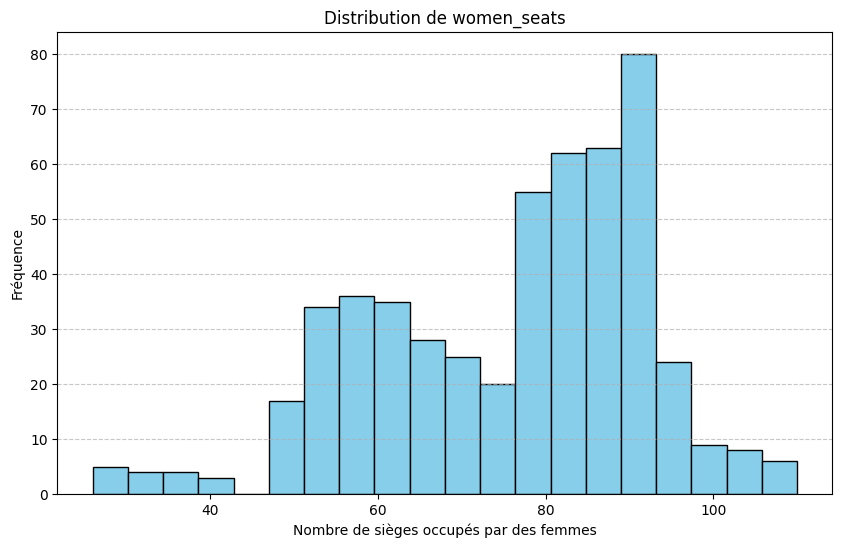

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_merged['years_since_suffrage'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Nombre de sièges occupés par des femmes')
plt.ylabel('Fréquence')
plt.title('Distribution de women_seats')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
#ANOVA TEST
# Créez des catégories pour women_seats en fonction des tranches de 10%
df_merged['Years_Since_Suffrage_category'] = pd.cut(df_merged['years_since_suffrage'], bins=[0, 60, 90, 140], labels=['low', 'medium', 'high'])

# Construisez une formule pour le modèle ANOVA
model = ols('women_seats ~ C(Years_Since_Suffrage_category)', data=df_merged).fit()

# Effectuez l'ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                                        sum_sq     df          F        PR(>F)
C(Years_Since_Suffrage_category)  11565.760883    2.0  56.835881  4.968135e-23
Residual                          52399.705466  515.0        NaN           NaN


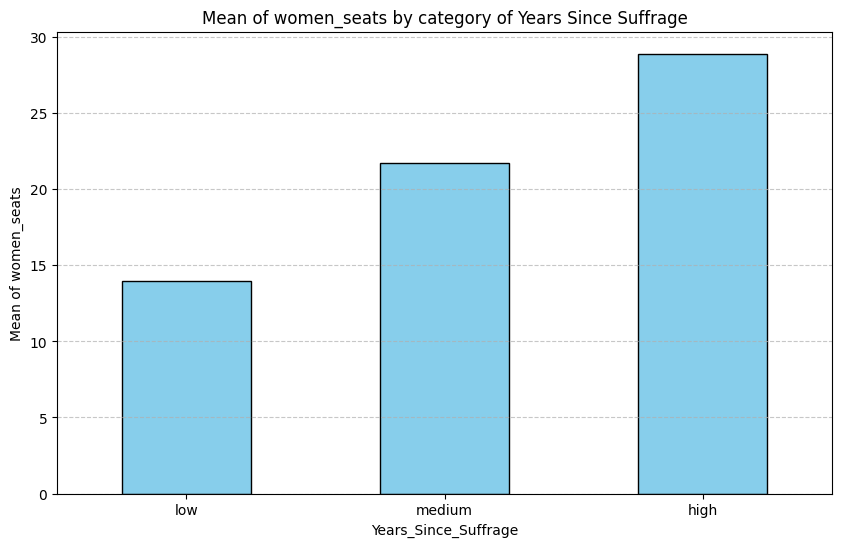

In [ ]:
# Calculer les moyennes de women_seats par groupe
means_by_category = df_merged.groupby('Years_Since_Suffrage_category')['women_seats'].mean()

# Créer un graphique en barres pour visualiser les moyennes
plt.figure(figsize=(10, 6))
means_by_category.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Years_Since_Suffrage')
plt.ylabel('Mean of women_seats')
plt.title('Mean of women_seats by category of Years Since Suffrage')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

####2SLS

In [ ]:
# Première étape : Régression de 'women_seats' sur 'years_since_suffrage' et d'autres contrôles
first_stage = smf.ols('women_seats ~ years_since_suffrage + log_gdp + polity + openness + education + co2', data=df_merged).fit()
df_merged['Women_Seats_hat'] = first_stage.fittedvalues  # Ajouter la variable prédite au DataFrame

# Deuxième étape : Régression de 'Stringency_Index' sur la variable prédite 'Women_Seats_hat' et d'autres contrôles
second_stage = smf.ols('stringency_index ~ Women_Seats_hat + log_gdp + polity + openness + education + co2', data=df_merged).fit()

# Afficher les résultats de la deuxième étape
print(first_stage.summary())
print(second_stage.summary())

df_merged.drop('Women_Seats_hat', axis=1, inplace=True)

                            OLS Regression Results                            
Dep. Variable:            women_seats   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     24.37
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.99e-25
Time:                        01:06:51   Log-Likelihood:                -1917.2
No. Observations:                 518   AIC:                             3848.
Df Residuals:                     511   BIC:                             3878.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.1183 

#### 2SLS with year fixed effect

In [ ]:
# Réinitialiser les indices de df_merged et convertir les colonnes d'année en chaînes de caractères
df_merged_reset = df_merged.reset_index()

# Créer des variables indicatrices pour les années et convertir les noms des colonnes en chaînes de caractères
year_dummies = pd.get_dummies(df_merged_reset['year'], drop_first=True)
year_dummies.columns = year_dummies.columns.astype(str)

# Ajouter les colonnes d'année modifiées au DataFrame
df_merged_with_year = pd.concat([df_merged_reset, year_dummies], axis=1)

In [ ]:
year_columns_str = ' + '.join(['Q("{}")'.format(col) for col in year_dummies.columns])
first_stage_formula = 'women_seats ~ years_since_suffrage + gdp + polity + openness + education + co2 + ' + year_columns_str
first_stage = smf.ols(first_stage_formula, data=df_merged_with_year).fit()
df_merged_with_year['Women_Seats_hat'] = first_stage.fittedvalues

In [ ]:
# Construire la formule pour la deuxième étape
second_stage_formula = 'stringency_index ~ Women_Seats_hat + gdp + polity + openness + education + co2 + ' + year_columns_str
second_stage = smf.ols(second_stage_formula, data=df_merged_with_year).fit()

# Afficher les résultats
print(first_stage.summary())
print(second_stage.summary())


                            OLS Regression Results                            
Dep. Variable:            women_seats   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     7.352
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           5.16e-19
Time:                        01:06:51   Log-Likelihood:                -1912.2
No. Observations:                 518   AIC:                             3868.
Df Residuals:                     496   BIC:                             3962.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4969 

#Tests ANOVA 2 Factors

##Tests ANOVA 2 Factors GDP & Polity

In [ ]:


# Définir les seuils pour catégoriser les variables
gdp_threshold = df_merged['gdp'].median()
Polity_threshold = df_merged['polity'].mean()
df_merged['Polity_Category'] = pd.cut(df_merged['polity'], bins=[-np.inf, Polity_threshold, np.inf], labels=['Low', 'High'])

# Créer des variables catégorielles
df_merged['GDP_Category'] = pd.cut(df_merged['gdp'], bins=[-np.inf, gdp_threshold, np.inf], labels=['Low', 'High'])


print(df_merged['GDP_Category'].value_counts())
print(df_merged['Polity_Category'].value_counts())


# Construire une formule pour le modèle ANOVA
model = ols('stringency_index ~ C(GDP_Category) + C(Polity_Category) + C(GDP_Category):C(Polity_Category)', data=df_merged).fit()

# Effectuer l'ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

Low     259
High    259
Name: GDP_Category, dtype: int64
High    404
Low     114
Name: Polity_Category, dtype: int64
                                        sum_sq     df           F  \
C(GDP_Category)                       0.638521    1.0    0.853429   
C(Polity_Category)                   87.793507    1.0  117.342321   
C(GDP_Category):C(Polity_Category)    0.833452    1.0    1.113969   
Residual                            384.565965  514.0         NaN   

                                          PR(>F)  
C(GDP_Category)                     3.560176e-01  
C(Polity_Category)                  9.067387e-25  
C(GDP_Category):C(Polity_Category)  2.917167e-01  
Residual                                     NaN  


C(GDP_Category) : sum_sq (Somme des Carrés) : 1.262385. Cela indique la variation totale expliquée par les catégories de PIB. df (Degrés de Liberté) : 1. Cela indique qu'il y a deux niveaux (Low et High) dans la variable catégorielle de PIB. F (Statistique F) : 2.735253. C'est la statistique de test pour évaluer l'importance de l'effet de la catégorie de PIB. PR(>F) (P-value) : Environ 0.099. C'est la probabilité d'observer une statistique aussi extrême que celle observée si l'hypothèse nulle était vraie. Ici, la valeur P est juste en dessous de 0.1, ce qui suggère une tendance vers la significativité, mais dans des contextes académiques traditionnels, elle ne serait généralement pas considérée comme statistiquement significative.
C(Polity_Category) : sum_sq : 41.232079. Cela montre une variation beaucoup plus importante expliquée par les catégories de système politique. df : 1. F : 89.338933. Cette valeur élevée indique que les différences dues aux catégories de système politique sont statistiquement très significatives. PR(>F) : Environ 2.36e-18. Cette valeur P extrêmement faible indique que l'effet de la catégorie de système politique sur l'indice de stringence est très significatif.
Interaction C(GDP_Category):C(Polity_Category) : sum_sq : 8.043183. Cela montre la variation due à l'interaction entre les catégories de PIB et de système politique. df : 1. F : 17.427436. Un F élevé suggère que l'interaction est également significative. PR(>F) : Environ 4.11e-05. La valeur P très faible indique que l'interaction entre les catégories de PIB et de système politique a un effet significatif sur l'indice de stringence.
Residual : sum_sq : 116.765622. C'est la variation totale non expliquée par les modèles. df : 253. Ce sont les degrés de liberté restants.

##Tests ANOVA 2 Factors Education & Polity

In [ ]:
# Définir les seuils pour catégoriser les variables
education_threshold = df_merged['education'].median()
Polity_threshold = df_merged['polity'].mean()
df_merged['Polity_Category'] = pd.cut(df_merged['polity'], bins=[-np.inf, Polity_threshold, np.inf], labels=['Low', 'High'])

# Créer des variables catégorielles
df_merged['Education_Category'] = pd.cut(df_merged['education'], bins=[-np.inf, education_threshold, np.inf], labels=['Low', 'High'])


print(df_merged['Education_Category'].value_counts())
print(df_merged['Polity_Category'].value_counts())


# Construire une formule pour le modèle ANOVA
model = ols('stringency_index ~ C(Education_Category) + C(Polity_Category) + C(Education_Category):C(Polity_Category)', data=df_merged).fit()

# Effectuer l'ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

Low     259
High    259
Name: Education_Category, dtype: int64
High    404
Low     114
Name: Polity_Category, dtype: int64
                                              sum_sq     df          F  \
C(Education_Category)                      34.453827    1.0  51.359645   
C(Polity_Category)                         59.511840    1.0  88.713135   
C(Education_Category):C(Polity_Category)    6.775131    1.0  10.099555   
Residual                                  344.808981  514.0        NaN   

                                                PR(>F)  
C(Education_Category)                     2.685929e-12  
C(Polity_Category)                        1.536896e-19  
C(Education_Category):C(Polity_Category)  1.572299e-03  
Residual                                           NaN  


##Tests ANOVA 2 Factors Women seat & Polity:

In [ ]:
# Définir les seuils pour catégoriser les variables
women_threshold = df_merged['women_seats'].median()
Polity_threshold = df_merged['polity'].mean()
df_merged['Polity_Category'] = pd.cut(df_merged['polity'], bins=[-np.inf, Polity_threshold, np.inf], labels=['Low', 'High'])

# Créer des variables catégorielles
df_merged['Women_Category'] = pd.cut(df_merged['women_seats'], bins=[-np.inf, women_threshold, np.inf], labels=['Low', 'High'])


print(df_merged['Women_Category'].value_counts())
print(df_merged['Polity_Category'].value_counts())


# Construire une formule pour le modèle ANOVA
model = ols('stringency_index ~ C(Women_Category) + C(Polity_Category) + C(Women_Category):C(Polity_Category)', data=df_merged).fit()

# Effectuer l'ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

Low     260
High    258
Name: Women_Category, dtype: int64
High    404
Low     114
Name: Polity_Category, dtype: int64
                                          sum_sq     df          F  \
C(Women_Category)                      34.471553    1.0  50.960043   
C(Polity_Category)                     59.766121    1.0  88.353551   
C(Women_Category):C(Polity_Category)    3.874799    1.0   5.728199   
Residual                              347.691587  514.0        NaN   

                                            PR(>F)  
C(Women_Category)                     3.232171e-12  
C(Polity_Category)                    1.794682e-19  
C(Women_Category):C(Polity_Category)  1.705231e-02  
Residual                                       NaN  


#Difference in Difference 📈

##<h3>Data QoG Gender Quotas</h3>

In [ ]:
# Import data from Quota Adoption and Reform over Time Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/qogdata_18_12_2023.xlsx"
df_qog_quota = pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["cname", "year", "qar_efqu"]
df_qog_quota = df_qog_quota[columns_to_keep]
df_qog_quota.rename(columns={'cname': 'country_name', 'qar_efqu': 'quota'}, inplace=True)
df_qog_quota['country_name'] = df_qog_quota['country_name'].replace('Netherlands (the)', 'Netherlands')

df_qog_quota

,country_name,year,quota
0,Afghanistan,1947,0
1,Afghanistan,1948,0
2,Afghanistan,1949,0
3,Afghanistan,1950,0
4,Afghanistan,1951,0
...,...,...,...
9948,Pakistan,1966,0
9949,Pakistan,1967,0
9950,Pakistan,1968,0
9951,Pakistan,1969,0


In [ ]:
#df_merged = df_merged.drop(columns=['quota'], errors='ignore')
df_merged_quota = pd.merge(df_merged, df_qog_quota, on=['country_name', 'year'], how='inner')
df_merged_quota

,country_name,year,index,country_code,women_seats,fertility_rate,gdp,openness,co2,education,...,normalized_polity,reflected_normalized_polity,log_reflected_normalized_polity,fertility_group,Years_Since_Suffrage_category,Polity_Category,GDP_Category,Education_Category,Women_Category,quota_y
0,Australia,1997,0,AUS,15.540541,1.778,60992.006910,37.980832,16.706176,11.068,...,1.0,0.1,-2.207275,Above Median,high,High,High,High,Low,0
1,Australia,1998,1,AUS,15.540541,1.762,63203.100413,39.992702,17.602334,11.052,...,1.0,0.1,-2.207275,Above Median,high,High,High,High,Low,0
2,Australia,1999,2,AUS,22.448980,1.755,65658.498095,39.029795,17.737243,11.036,...,1.0,0.1,-2.207275,Above Median,high,High,High,High,High,0
3,Australia,2000,3,AUS,22.972973,1.756,67456.847783,40.935211,17.837318,11.020,...,1.0,0.1,-2.207275,Above Median,high,High,High,High,High,0
4,Australia,2002,4,AUS,25.333333,1.756,69849.773355,41.449092,18.123211,11.160,...,1.0,0.1,-2.207275,Above Median,high,High,High,High,High,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,Switzerland,2008,472,CHE,28.500000,1.480,79378.239792,116.778000,5.879238,11.638,...,1.0,0.1,-2.207275,Below Median,low,High,High,High,High,0
421,Switzerland,2009,473,CHE,29.000000,1.500,76591.619962,109.775985,5.639147,12.154,...,1.0,0.1,-2.207275,Below Median,low,High,High,High,High,0
422,Switzerland,2010,474,CHE,29.000000,1.520,78256.444644,120.065123,5.777422,12.670,...,1.0,0.1,-2.207275,Below Median,low,High,High,High,High,0
423,Switzerland,2011,475,CHE,28.500000,1.520,78794.332388,125.556273,5.206045,12.670,...,1.0,0.1,-2.207275,Below Median,low,High,High,High,High,0


In [ ]:
# Count number of observations by country
country_counts = df_merged_quota.groupby(['country_name']).size().reset_index(name='counts')
df_country_counts = country_counts.groupby('country_name')['counts'].sum().reset_index()
df_country_counts

,country_name,counts
0,Australia,15
1,Austria,14
2,Belgium,16
3,Brazil,16
4,Canada,15
5,China,15
6,Czechia,16
7,Denmark,15
8,Finland,16
9,France,16


##<h3>Stringency Index Patterns



Erreurs Standard et Intervalle de Confiance : Si vous trouvez que les erreurs standard des coefficients sont très grandes ou que les intervalles de confiance sont anormalement larges, cela peut également indiquer une multicollinéarité.

##<h4>Case 1: France and Portugal

In [ ]:
#Getting data from Portugal and France from 1991 until 2006 (Env Pol)

df_pf = df_qog[((df_qog['country_name'] == 'France') |
                              (df_qog['country_name'] == 'Portugal')) &
                              (df_qog['year'] >= 1991) &
                              (df_qog['year'] <= 2006)].copy() #until 2005 because that's when Portugal implemented its quota

#Add gender quotas column
df_merged_pf = pd.merge(df_pf, df_qog_quota, on=['country_name', 'year'], how='inner')

#df_merged_bpp.rename(columns={'quota': 'quota'}, inplace=True)

#Show table
df_merged_pf

KeyError: ignored

In [ ]:
# Define colors for each country
colors = {'France': 'red', 'Portugal': 'green' }

# Plotting
plt.figure(figsize=(12, 6))

# Plot data and quota implementation for each country
for country in ['France', 'Portugal']:
    country_data = df_merged_pf[df_merged_pf['country_name'] == country]

    # Plot stringency index
    plt.plot(country_data['year'], country_data['stringency_index'], label=f'{country}', color=colors[country])

    # Find the first year where the quota was implemented (when 'quota' changes from 0 to 1)
    quota_change = country_data['quota'].diff() == 1
    if quota_change.any():
        # Get the year where the change occurred
        year_of_quota_implementation = country_data[quota_change]['year'].values[0]
        # Plot a vertical line for the year of quota implementation
        plt.axvline(x=year_of_quota_implementation, linestyle='--', color=colors[country], label=f'{country} Quota Implementation')

# Plot the vertical line for the quota implementation in France in 2000
plt.axvline(x=2000, linestyle=':', color='red', label='France Quota Implementation')
#plt.text(2000.5, plt.gca().get_ylim()[1], 'Quota implemented in France', rotation=90, color='red', fontsize=8)

# Adding title and labels
plt.title('Stringency Index Over Time (1992-2012) for France and Portugal')
plt.xlabel('Year')
plt.ylabel('Stringency Index')
plt.legend()
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Extract unique years
unique_years = df_merged_pf['year'].unique()

# Extract unique country names
unique_countries = df_merged_pf['country_name'].unique()

# Create a new DataFrame with 'year' as index and countries as columns
# df_did_table with NaNs or another default value
df_did_table = pd.DataFrame(index=unique_years, columns=unique_countries)

# Reset index to turn 'year' back into a column
#df_did_table.reset_index(inplace=True)
#df_did_table.rename(columns={'index': 'year'}, inplace=True)

for year in df_did_table.index:
    for country in df_did_table.columns:  # Exclude the 'year' column
        # Find the stringency_index value in df for the specific year and country
        value = df_merged_pf[(df_merged_pf['year'] == year) & (df_merged_pf['country_name'] == country)]['stringency_index'].values
        # Assign the value to df_did_table; use .iloc[0] if you're sure there's always exactly one value
        df_did_table.at[year, country] = value[0] if len(value) > 0 else None

# Display the final DataFrame
df_did_table

In [ ]:
# Add a new column 'quota_effect' to df_did_table
# To account the lag effect we set value 1 from 2002 on
df_did_table['quota_effect'] = df_did_table.index.map(lambda x: 1 if x >= 2002 else 0)

df_did_table

In [ ]:
results_did = df_did_table.groupby('quota_effect').mean()
results_did

In [ ]:
results_did['France']-results_did['Portugal']

In [ ]:
#Diffindiff result
(results_did['France']-results_did['Portugal']).diff()

##<h4>Case 1: Indonesia and Brazil

In [ ]:
df_bi = df_qog[((df_qog['country_name'] == 'Indonesia') |
                              (df_qog['country_name'] == 'Brazil')) &
                              (df_qog['year'] >= 1996) &
                              (df_qog['year'] <= 2012)].copy()

#Add gender quotas column
df_merged_bi = pd.merge(df_bi, df_qog_quota, on=['country_name', 'year'], how='inner')

#df_merged_bpp.rename(columns={'quota': 'quota'}, inplace=True)

#Show table
df_merged_bi

In [ ]:
# Define colors for each country
colors = {'Indonesia': 'red', 'Brazil': 'green' }

# Plotting
plt.figure(figsize=(12, 6))

# Plot data and quota implementation for each country
for country in ['Indonesia', 'Brazil']:
    country_data = df_merged_bi[df_merged_bi['country_name'] == country]

    # Plot stringency index
    plt.plot(country_data['year'], country_data['stringency_index'], label=f'{country}', color=colors[country])

    # Find the first year where the quota was implemented (when 'quota' changes from 0 to 1)
    quota_change = country_data['quota'].diff() == 1
    if quota_change.any():
        # Get the year where the change occurred
        year_of_quota_implementation = country_data[quota_change]['year'].values[0]
        # Plot a vertical line for the year of quota implementation
        plt.axvline(x=year_of_quota_implementation, linestyle='--', color=colors[country], label=f'{country} Quota Implementation')


# Adding title and labels
plt.title('Stringency Index Over Time (1992-2012) for France and Portugal')
plt.xlabel('Year')
plt.ylabel('Stringency Index')
plt.legend()
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Extract unique years
unique_years = df_merged_bi['year'].unique()

# Extract unique country names
unique_countries = df_merged_bi['country_name'].unique()

# Create a new DataFrame with 'year' as index and countries as columns
df_did_table = pd.DataFrame(index=unique_years, columns=unique_countries)

# Initialize a new column 'quota' in df_did_table
df_did_table['quota_effect'] = None

# Loop over the years in the index
for year in df_did_table.index:
    # Find the quota value for Indonesia in the specific year
    quota_value = df_merged_bi[(df_merged_bi['year'] == year) & (df_merged_bi['country_name'] == 'Indonesia')]['quota'].values
    # Assign the quota value to df_did_table
    if len(quota_value) > 0:
        df_did_table.at[year, 'quota_effect'] = quota_value[0]

    condition = df_did_table.index < 2010
    df_did_table.loc[condition, 'quota_effect'] = 0


    # Loop over the countries in the columns
    for country in df_did_table.columns[:-1]:  # Exclude the 'quota' column
        # Find the stringency_index value for the specific year and country
        value = df_merged_bi[(df_merged_bi['year'] == year) & (df_merged_bi['country_name'] == country)]['stringency_index'].values
        # Assign the value to df_did_table
        df_did_table.at[year, country] = value[0] if len(value) > 0 else None

# Display the final DataFrame
df_did_table

In [ ]:
results_did = df_did_table.groupby('quota_effect').mean()
results_did

In [ ]:
results_did['Indonesia']-results_did['Brazil']

In [ ]:
#Diffindiff result
(results_did['Indonesia']-results_did['Brazil']).diff()

# Archives

## <h3>3) Chapel Hill Expert Survey (CHES)</h3>
Calculating the <b>left orientation index of parliaments</b>.

In [ ]:
# Import data from Chapel Hill Expert Survey Dataset
url = "https://raw.githubusercontent.com/vgentile98/zebraproject/main/data/CHES_TREND_1999-2019.xlsx"
df_ches=pd.read_excel(url)

# Keep only relevant columns
columns_to_keep = ["country", "year", "party", "seat", "lrgen"]
df_ches = df_ches[columns_to_keep]

df_ches

In [ ]:
# Create a dictionary to map country IDs to names
id_to_name = {
    1: 'Belgium', 2: 'Denmark', 3: 'Germany', 4: 'Greece', 5: 'Spain',
    6: 'France', 7: 'Ireland', 8: 'Italy', 10: 'Netherlands', 11: 'United Kingdom',
    12: 'Portugal', 13: 'Austria', 14: 'Finland', 16: 'Sweden',
    20: 'Bulgaria', 21: 'Czech Republic', 22: 'Estonia', 23: 'Hungary', 24: 'Latvia',
    25: 'Lithuania', 26: 'Poland', 27: 'Romania', 28: 'Slovakia', 29: 'Slovenia',
    31: 'Croatia', 37: 'Malta', 38: 'Luxembourg', 40: 'Cyprus'
}

# Replace the "country" column values with country names
df_ches['country'] = df_ches['country'].map(id_to_name)

df_ches

In [ ]:
# Calculate weighted ideology for each party
df_ches['weighted_ideology'] = df_ches['lrgen'] * df_ches['seat']

# Group by country and year, and sum the weighted ideologies
df_ches_grouped = df_ches.groupby(['country', 'year']).apply(
    lambda x: pd.Series({
        'total_weighted_ideology': (x['weighted_ideology'].sum() / x['seat'].sum())
    })
).reset_index()

# Rename columns
df_ches_grouped.rename(columns={'country': 'country_name'}, inplace=True)

# Display the dataframe
df_ches_grouped

# Calculate parliament ideology per country and per year (ideology of the parliament based on a weighted party average)
#df_ches['weighted_ideology'] = (df_ches['lrgen'] * df_ches['seat']).groupby([df_ches['country'], df_ches['year']]).transform('sum') / df_ches.groupby([df_ches['country'], df_ches['year']])['seat'].transform('sum')

# Select & rename columns
#df_ches = df_ches[['country', 'year', 'weighted_ideology']]
#df_ches.rename(columns={'country': 'country_name'}, inplace=True)

#df_ches

In [ ]:
# Ensure 'year' is type int
df_ches_grouped['year'] = df_ches_grouped['year'].astype(int)

# Interpolation for each country
all_years = np.arange(1999, 2020)  # De 1999 à 2019 inclus
interpolated_data = []

for country in df_ches_grouped['country_name'].unique():
    country_df = df_ches_grouped[df_ches_grouped['country_name'] == country]
    country_df = country_df.set_index('year').reindex(all_years).reset_index()
    country_df['country_name'] = country
    country_df['total_weighted_ideology'] = country_df['total_weighted_ideology'].interpolate()
    interpolated_data.append(country_df)

interpolated_df = pd.concat(interpolated_data)

print(interpolated_df)

In [ ]:
# Grouping by country_name and computing the mean of total_weighted_ideology
sample_df_map = interpolated_df.groupby(['country_name'])['total_weighted_ideology'].mean().reset_index()

# Creating the interactive map using the aggregated data
sample_fig = px.choropleth(
    sample_df_map,
    locations='country_name',
    locationmode='country names',
    color='total_weighted_ideology',
    hover_name='country_name',
    color_continuous_scale=px.colors.sequential.Blues
)
# Update layout to center the title
sample_fig.update_layout(
    title_text="Average total weighted ideology in National Parliaments by Country",
    title_x=0.5,  # Centering the title
    coloraxis_colorbar=dict(
        title="Avg total_weighted_ideology"  # Name of the color bar
        #tickvals=[sample_df_map['women_seats'].min(), sample_df_map['women_seats'].max()]  # Specific tick values

    ),
    geo=dict(
        showframe=False,  # This removes the frame around the map
        projection_type='equirectangular',  # Projection style
        landcolor='lightgray',  # Set countries with no data to light gray
        countrycolor='darkgray'  # Optional: Set country borders to dark gray
    )
)
sample_fig.show()

##<h3>Women in Parliament Patterns (OUTDATED)

In [ ]:
# Plotting women seats over time for all countries

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(12, 12))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()

df_merged.set_index(['country_name', 'year'], inplace=True)

highlighted_countries = ['Denmark', 'Finland', 'India', 'Japan']

plot_women_seats(df_merged, highlighted_countries)

In [ ]:
# Plotting women seats over time for Germany and Ireland

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Germany', 'Ireland']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)


In [ ]:
# Plotting women seats over time for Netherlands and France

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Netherlands', 'France']

filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Denmark and Australia

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Denmark', 'Australia']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Indonesia and India

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['India', 'Indonesia']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Canada and Portugal

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Canada', 'Portugal']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

In [ ]:
# Plotting women seats over time for Spain and Portugal

def plot_women_seats(df, highlighted_countries):
    plt.figure(figsize=(6, 6))

    for country in df.index.get_level_values(0).unique():
        country_data = df.xs(country, level="country_name")
        # Removing rows with missing 'women_seats' data
        valid_data = country_data.dropna(subset=['women_seats'])
        if not valid_data.empty:
            # Highlight specific countries with thicker lines
            if country in highlighted_countries:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=2.5)
            else:
                plt.plot(valid_data.index, valid_data['women_seats'], label=country, linewidth=1)
            # Annotate the last point with the country name
            plt.text(valid_data.index[-1], valid_data['women_seats'].iloc[-1], country)

    plt.xlabel('Year')
    plt.ylabel('Number of Women Seats in Parliament')
    plt.title('Women Seats in Parliament Over Time by Country')
    plt.show()


selected_countries = ['Spain', 'Portugal']
filtered_df = df_merged[df_merged.index.get_level_values(0).isin(selected_countries)]

highlighted_countries = []

plot_women_seats(filtered_df, highlighted_countries)

# Quick visualisation for final article

In [ ]:
# Calculate the median of fertility_rate
fertility_median = df_merged['fertility_rate'].median()

# Create a new column to indicate if fertility_rate is above or below the median
df_merged['fertility_group'] = ['Above Median' if x > fertility_median else 'Below Median'
                                               for x in df_merged['fertility_rate']]

# Plot the scatter plot with two regression lines using lmplot
lm = sns.lmplot(x='stringency_index',
                y='women_seats',
                hue='fertility_group',
                data=df_merged,
                height=5,
                aspect=1.5)

lm.set_axis_labels("Stringency index ", "Percentage of Women seats in national parlement")
lm.fig.suptitle("Relationship between Stringency index and percentage of women seats in national parlement by fertility rate group", y=1.03)

plt.show()

In [ ]:
sns.regplot(x='stringency_index',
            y='women_seats',
            data=df_merged,
            scatter_kws={'color': 'black'},  # Paramètres du scatter plot
            line_kws={'color': 'blue'}        # Paramètres de la ligne de régression
           )

plt.title("Scatter plot of percentage of women seat in national parlements and stringency index")
plt.xlabel("Stringency index")
plt.ylabel("%Women seats")
plt.show()

In [ ]:
#plt.figure(figsize=(10, 6))
#plt.hist(df_merged['women_seats'], bins=20, color='skyblue', edgecolor='black')plt.xlabel('Nombre de sièges occupés par des femmes'plt.ylabel('Fréquence')
#plt.title('Distribution de women_seats')
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.show()

In [ ]:
# Créez des catégories pour women_seats en fonction des tranches de 10%
df_merged['women_seats_category'] = pd.cut(df_merged['women_seats'], bins=[0, 10, 20, 30, 40, 50], labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%'])

# Construisez une formule pour le modèle ANOVA
model = ols('stringency_index ~ C(women_seats_category)', data=df_merged).fit()

# Effectuez l'ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

In [ ]:
# Calculer les moyennes de stringency_index par groupe
means_by_category = df_merged.groupby('women_seats_category')['stringency_index'].mean()

# Créer un graphique en barres pour visualiser les moyennes
plt.figure(figsize=(10, 6))
means_by_category.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Share of women seats')
plt.ylabel('Mean of stringency_index')
plt.title('Mean of stringency_index by category of share of women seat')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Calculer la matrice de corrélation
corr_matrix = df_merged[['women_seats', 'fertility_rate', 'log_gdp', 'openness', 'co2', 'education', 'stringency_index', 'polity', 'years_since_suffrage']].corr()

# Créer une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')

# Ajouter des titres et des labels
plt.title('Matrice de Corrélation des Variables')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()
